In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm
import random
import os
import json
import numpy as np

import george
from functools import partial
import scipy.optimize as op
from astropy.table import Table, vstack
from gaussian_process import *

df = pd.read_csv('gp_objects_gp1000.csv')
display(df)
obj = sorted(df.obj_id.unique())

/tmp/ipykernel_67004/4028664106.py:16: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('gp_objects_gp1000.csv')


mjd   flux_ztfg   flux_ztfr  flux_error_ztfg  flux_error_ztfr  \
0      58226.340532  136.473151   99.008321        20.223566         1.245737   
1      58226.390513  139.022248  101.683596        19.834904         1.079511   
2      58226.440494  141.589596  104.383825        19.445064         1.085820   
3      58226.490474  144.174698  107.090648        19.053877         1.235566   
4      58226.540455  146.777048  109.794837        18.661182         1.460953   
...             ...         ...         ...              ...              ...   
71996  60485.304708   33.104947   36.051876        20.273348         3.441576   
71997  60485.313841   33.093513   36.039692        20.264562         3.332267   
71998  60485.322973   33.081261   36.026243        20.258811         3.251571   
71999  60485.332106   33.068191   36.011512        20.256105         3.202154   
72000  60485.341238   33.054302   35.995481        20.256452         3.185979   

      type        obj_id         mjd_0 redshift  flux_ztfi  ...   mag_ztfg  \
0      Ibn  ZTF18aakuewf  58226.340532   0.0636        NaN  ...  18.562382   
1      Ibn  ZTF18aakuewf  58226.340532   0.0636        NaN  ...  18.542289   
2      Ibn  ZTF18aakuewf  58226.340532   0.0636        NaN  ...  18.522422   
3      Ibn  ZTF18aakuewf  58226.340532   0.0636        NaN  ...  18.502777   
4      Ibn  ZTF18aakuewf  58226.340532   0.0636        NaN  ...  18.483355   
...    ...           ...           ...      ...        ...  ...        ...   
71996   II  ZTF24aascytf  60476.217836    0.038  33.927364  ...  20.100268   
71997   II  ZTF24aascytf  60476.217836    0.038  33.912465  ...  20.100643   
71998   II  ZTF24aascytf  60476.217836    0.038  33.896745  ...  20.101045   
71999   II  ZTF24aascytf  60476.217836    0.038  33.880203  ...  20.101474   
72000   II  ZTF24aascytf  60476.217836    0.038  33.862840  ...  20.101930   

       abs_mag_ztfg  mag_error_ztfg   mag_ztfr  abs_mag_ztfr  mag_error_ztfr  \
0        -13.788384        0.160892  18.910821    -13.439945        0.013661   
1        -13.808476        0.154907  18.881873    -13.468893        0.011527   
2        -13.828344        0.149108  18.853417    -13.497349        0.011294   
3        -13.847988        0.143489  18.825621    -13.525144        0.012527   
4        -13.867411        0.138040  18.798545    -13.552220        0.014447   
...             ...             ...        ...           ...             ...   
71996    -11.092596        0.664901  20.007680    -11.185184        0.103646   
71997    -11.092221        0.664842  20.008047    -11.184817        0.100388   
71998    -11.091819        0.664900  20.008453    -11.184411        0.097994   
71999    -11.091390        0.665074  20.008897    -11.183967        0.096544   
72000    -11.090934        0.665365  20.009380    -11.183484        0.096099   

        mag_ztfi  abs_mag_ztfi  mag_error_ztfi         t  
0            NaN           NaN             NaN  0.000000  
1            NaN           NaN             NaN  0.049981  
2            NaN           NaN             NaN  0.099961  
3            NaN           NaN             NaN  0.149942  
4            NaN           NaN             NaN  0.199923  
...          ...           ...             ...       ...  
71996  20.073625    -11.119239        0.616174  9.086873  
71997  20.074102    -11.118762        0.616131  9.096005  
71998  20.074605    -11.118259        0.616210  9.105138  
71999  20.075135    -11.117729        0.616410  9.114270  
72000  20.075692    -11.117172        0.616733  9.123403  

[72001 rows x 21 columns]

In [18]:
color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow'}
def plot_gp(obj_model, number_col=4, show_title=True, show_legend=True):
    color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow'}
    f, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('Time (mjd)')
    ax.set_ylabel('Flux') 
    if show_title:
        obj_id = obj_model['obj_id'].iloc[0]
        ax.set_title(f'Light Curve for Object ID: {obj_id} | Type: {obj_model["type"].iloc[0]}')
    if show_legend:
        ax.legend(ncol=number_col)

    # Plotting model data if available
    if obj_model is not None:
        # Iterate over the filters present in the obj_model DataFrame
        for column in obj_model.columns:
            if 'flux' in column and column != 'mjd' and 'abs' not in column:
                filter_name = column.split('_')[1]
                if filter_name in color_dict:
                    if not all(obj_model[column] == -1):
                        ax.plot(obj_model['t'], obj_model[column], label=f'Model {filter_name}', color=color_dict[filter_name])
    
                        # Plot error band if error data is available
                        error_column = f'flux_error_{filter_name}'
                        if error_column in obj_model.columns:
                            model_flux_error = obj_model[error_column]
                            ax.fill_between(obj_model['t'], obj_model[column]-model_flux_error, obj_model[column]+model_flux_error, color=color_dict[filter_name], alpha=0.20)

    return f,ax

In [19]:
def cut_data(df, obj_id, cutoff, plot=True):
    obj_model = df[df['obj_id'] == obj_id]
    if plot:
        f, ax = plot_gp(obj_model)
        ax.axvline(cutoff, color='black', linestyle='--', label='Cutoff')
        plt.show()

    obj_model = obj_model[obj_model['t'] < cutoff]
    combined_df = pd.concat([df[df['obj_id'] != obj_id], obj_model])
    return combined_df

In [20]:
obj[27]

'ZTF20acozryr'

In [21]:
df[df['obj_id'] == obj[30]]

mjd  flux_ztfg  flux_ztfr  flux_error_ztfg  flux_error_ztfr  \
30000  59215.423935  85.374642  48.127260        13.369288        16.339748   
30001  59215.473862  85.090440  47.967696        13.292463        16.169958   
30002  59215.523788  84.803178  47.809294        13.218421        16.000350   
30003  59215.573715  84.512958  47.652101        13.147104        15.830930   
30004  59215.623641  84.219887  47.496163        13.078451        15.661702   
...             ...        ...        ...              ...              ...   
30995  59265.100815  24.329480  72.392327        10.606644         2.348583   
30996  59265.150741  24.272965  72.168410        10.783509         2.409474   
30997  59265.200668  24.216345  71.944592        10.960475         2.476394   
30998  59265.250594  24.159620  71.721024        11.137531         2.549509   
30999  59265.300521  24.102787  71.497819        11.314670         2.628919   

      type        obj_id         mjd_0  redshift  flux_ztfi  ...   mag_ztfg  \
30000  IIb  ZTF21aaabrpu  59215.423935  0.027172  37.895474  ...  19.071678   
30001  IIb  ZTF21aaabrpu  59215.423935  0.027172  37.940301  ...  19.075298   
30002  IIb  ZTF21aaabrpu  59215.423935  0.027172  37.987126  ...  19.078970   
30003  IIb  ZTF21aaabrpu  59215.423935  0.027172  38.035970  ...  19.082692   
30004  IIb  ZTF21aaabrpu  59215.423935  0.027172  38.086852  ...  19.086463   
...    ...           ...           ...       ...        ...  ...        ...   
30995  IIb  ZTF21aaabrpu  59215.423935  0.027172  86.230208  ...  20.434668   
30996  IIb  ZTF21aaabrpu  59215.423935  0.027172  86.059716  ...  20.437193   
30997  IIb  ZTF21aaabrpu  59215.423935  0.027172  85.888701  ...  20.439729   
30998  IIb  ZTF21aaabrpu  59215.423935  0.027172  85.717168  ...  20.442275   
30999  IIb  ZTF21aaabrpu  59215.423935  0.027172  85.545123  ...  20.444832   

       abs_mag_ztfg  mag_error_ztfg   mag_ztfr  abs_mag_ztfr  mag_error_ztfr  \
30000    -11.375703        0.170021  19.694022    -10.753358        0.368620   
30001    -11.372082        0.169609  19.697628    -10.749753        0.366003   
30002    -11.368411        0.169236  19.701219    -10.746161        0.363364   
30003    -11.364689        0.168901  19.704795    -10.742586        0.360702   
30004    -11.360917        0.168603  19.708354    -10.739027        0.358018   
...             ...             ...        ...           ...             ...   
30995    -10.012713        0.473336  19.250769    -11.196612        0.035224   
30996    -10.010188        0.482349  19.254132    -11.193248        0.036249   
30997    -10.007652        0.491411  19.257505    -11.189876        0.037372   
30998    -10.005106        0.500522  19.260884    -11.186497        0.038595   
30999    -10.002549        0.509682  19.264268    -11.183112        0.039922   

        mag_ztfi  abs_mag_ztfi  mag_error_ztfi          t  
30000  19.953532    -10.493849        0.746163   0.000000  
30001  19.952248    -10.495132        0.740427   0.049927  
30002  19.950909    -10.496472        0.734669   0.099853  
30003  19.949514    -10.497867        0.728888   0.149780  
30004  19.948062    -10.499318        0.723086   0.199706  
...          ...           ...             ...        ...  
30995  19.060851    -11.386529        0.138250  49.676880  
30996  19.063000    -11.384380        0.140258  49.726806  
30997  19.065160    -11.382221        0.142289  49.776733  
30998  19.067330    -11.380050        0.144343  49.826659  
30999  19.069512    -11.377869        0.146419  49.876586  

[1000 rows x 21 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


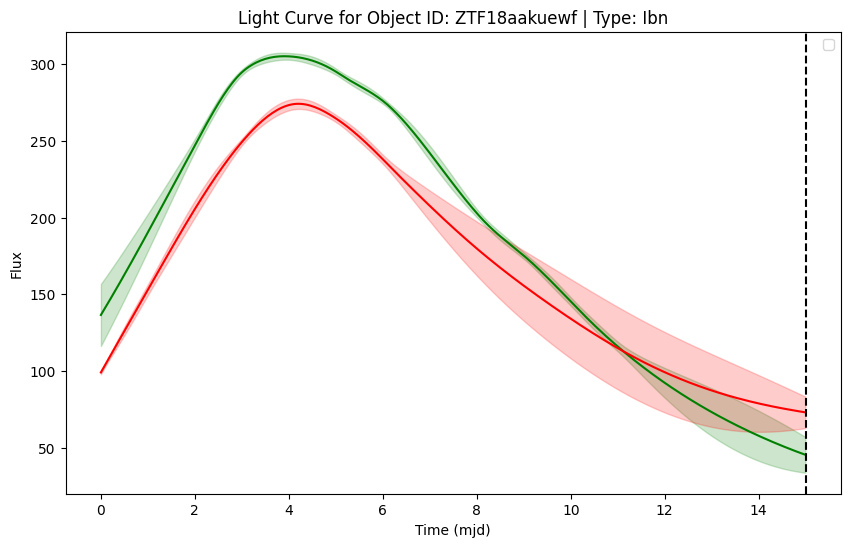

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


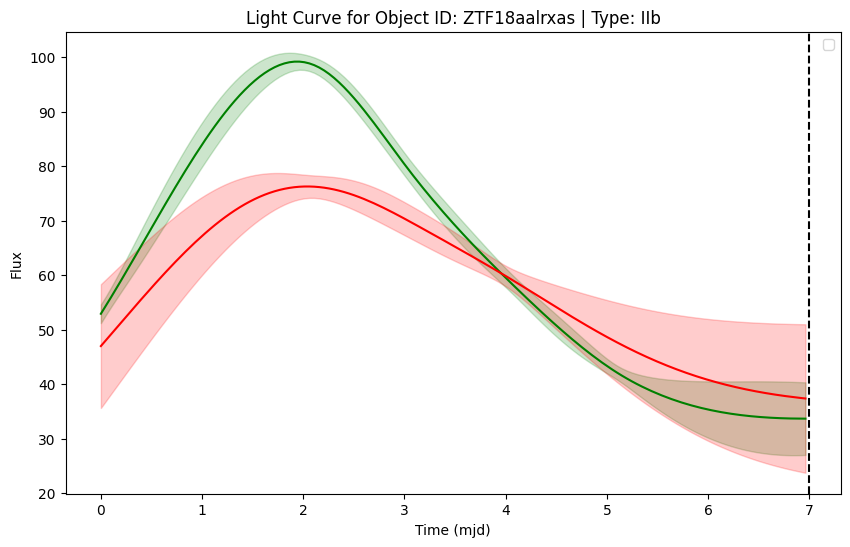

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


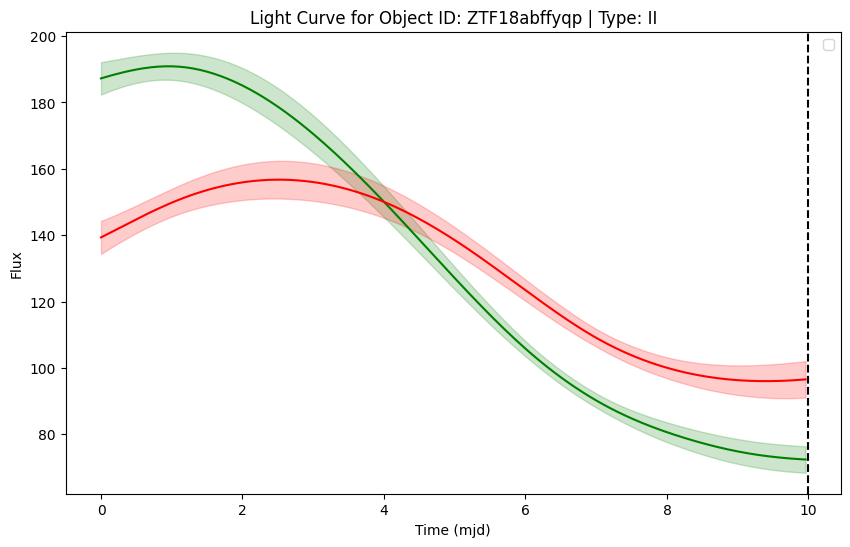

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


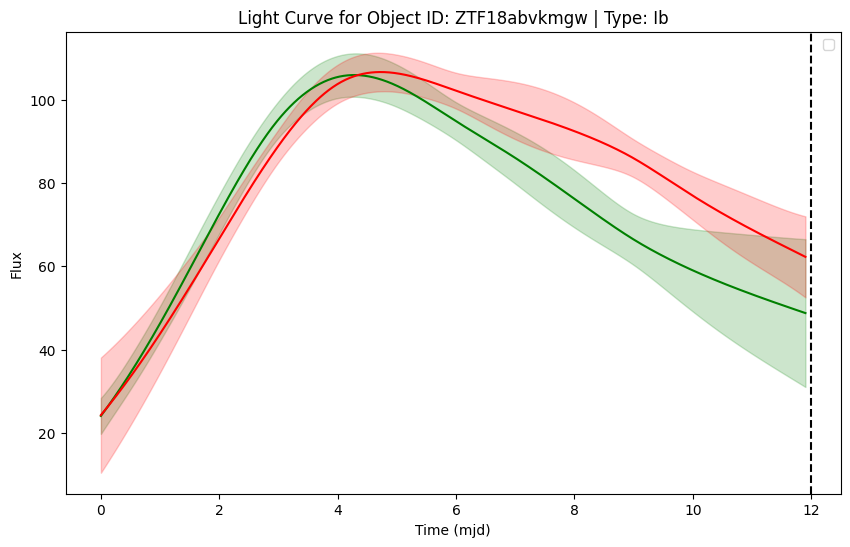

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


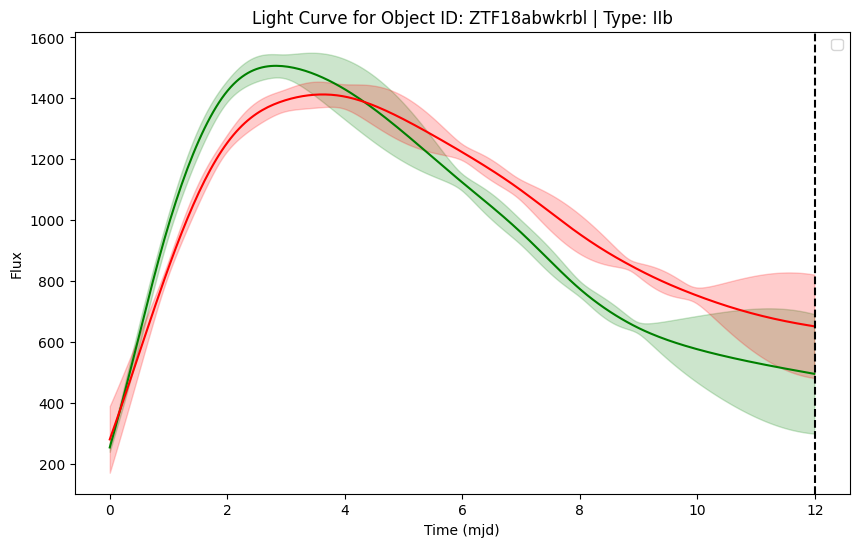

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


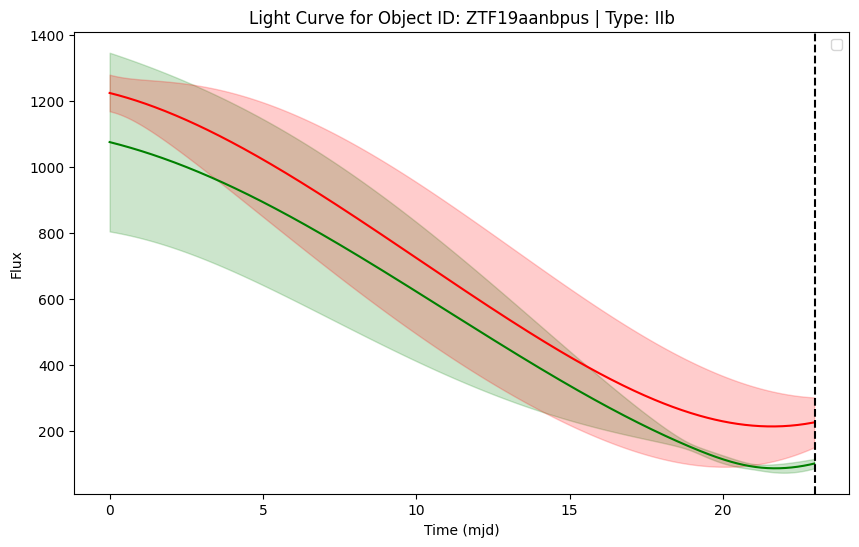

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


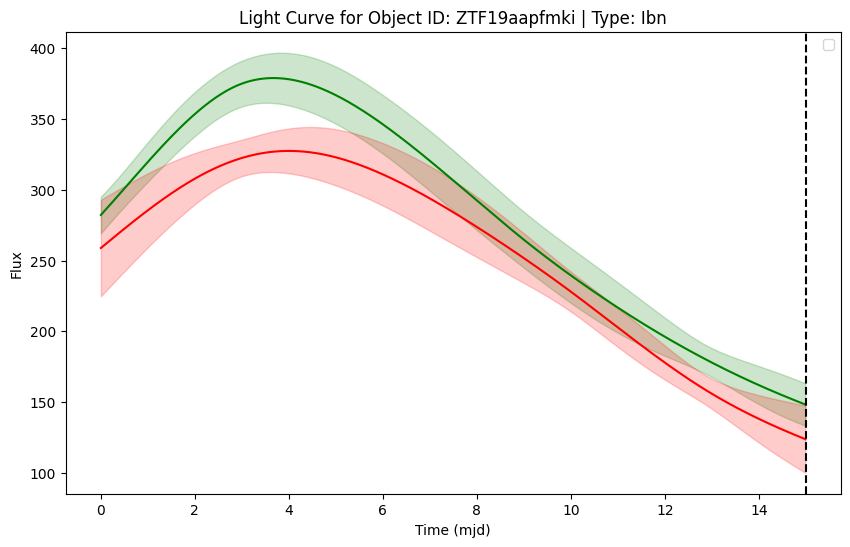

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


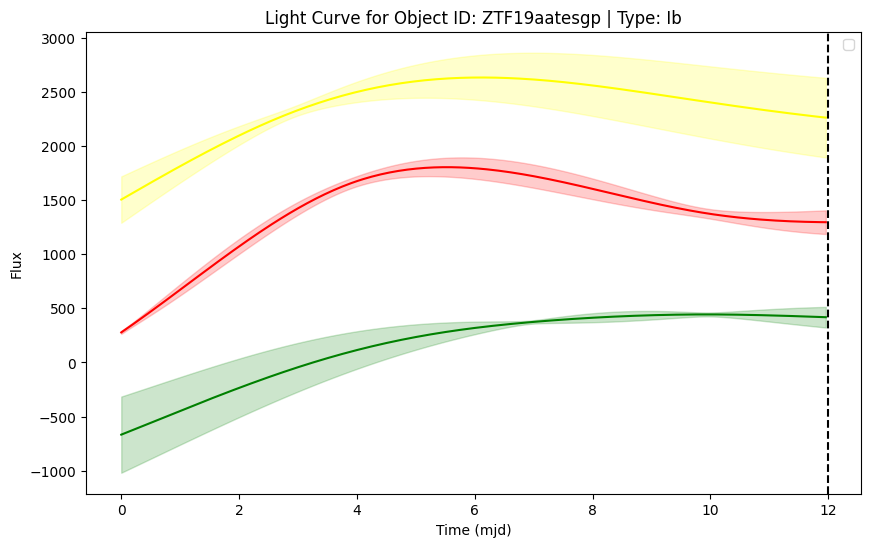

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


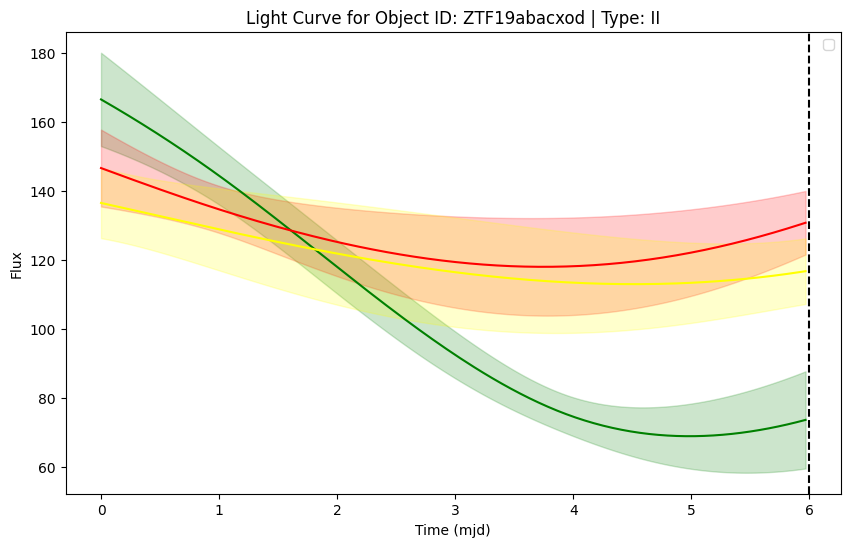

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


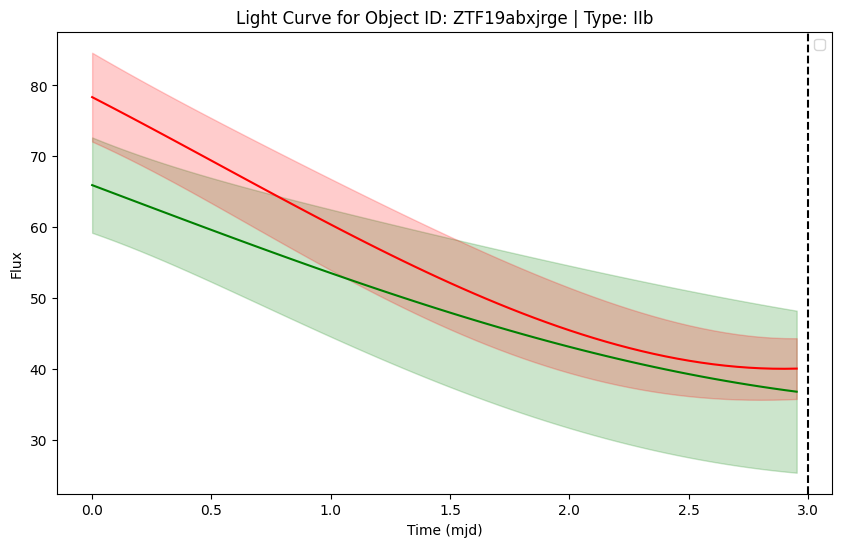

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


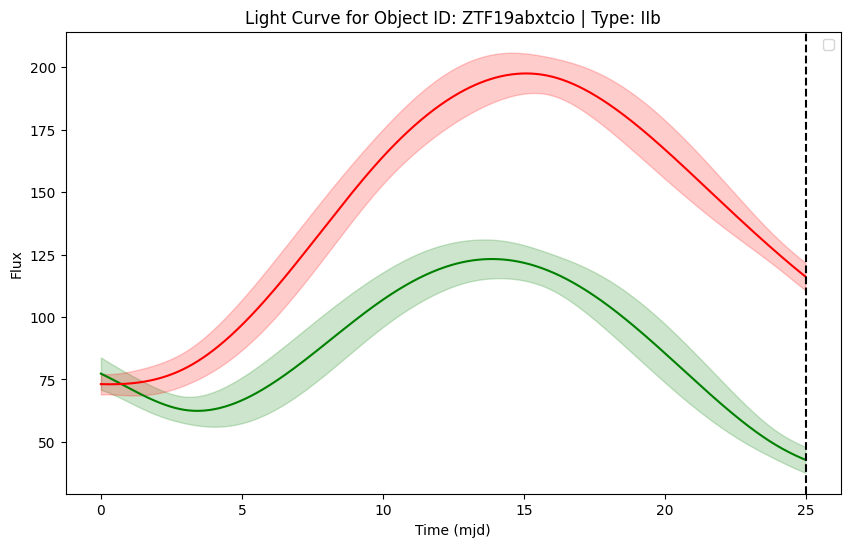

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


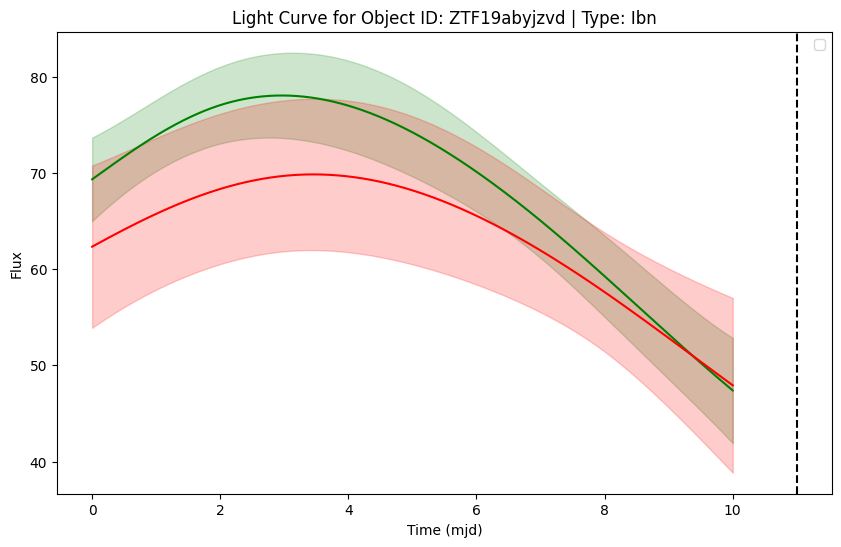

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


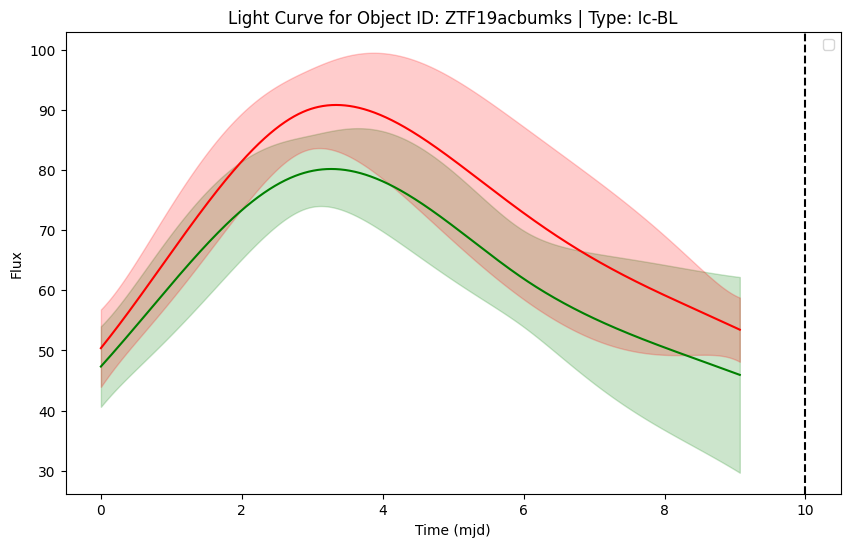

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


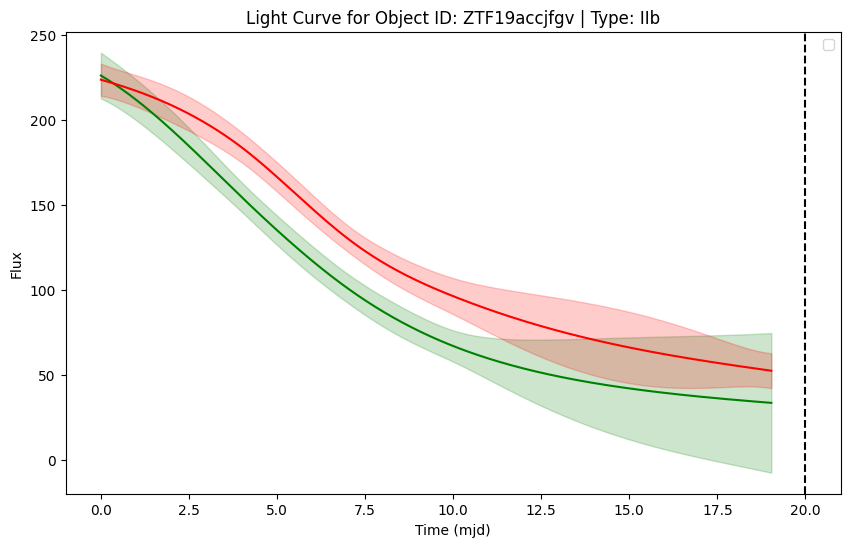

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


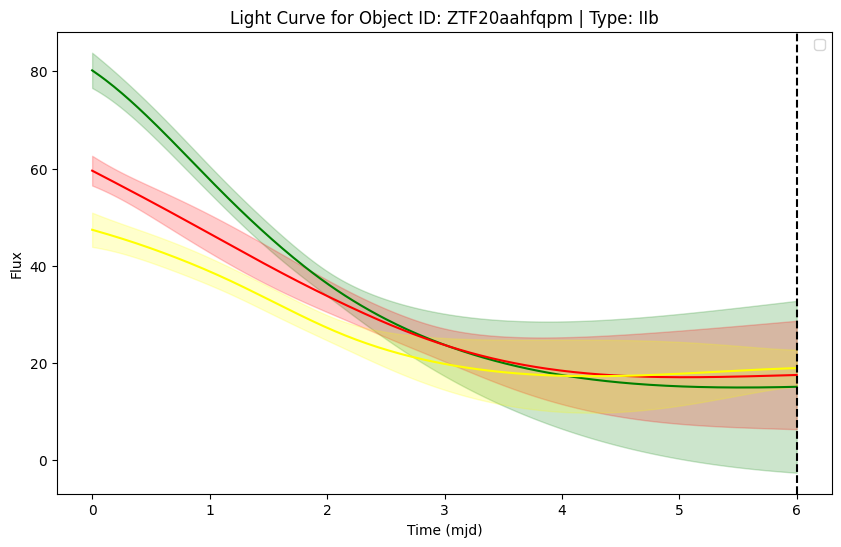

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


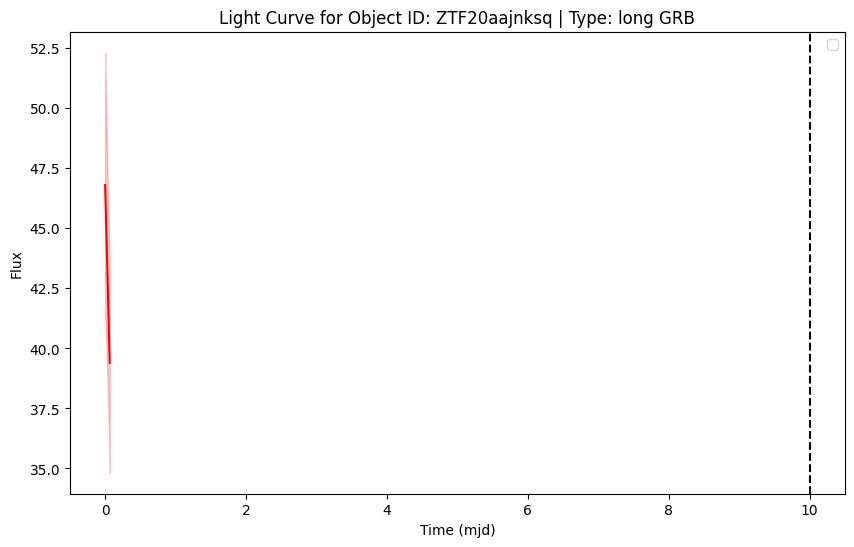

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


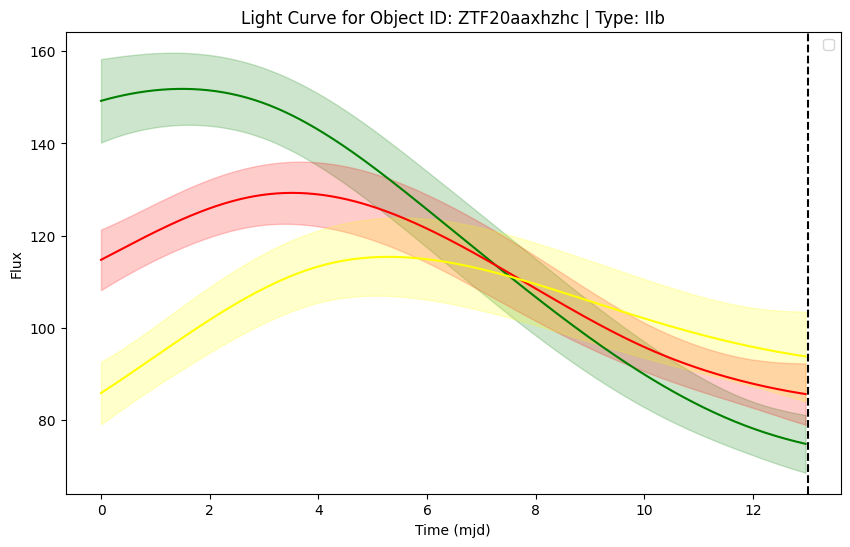

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


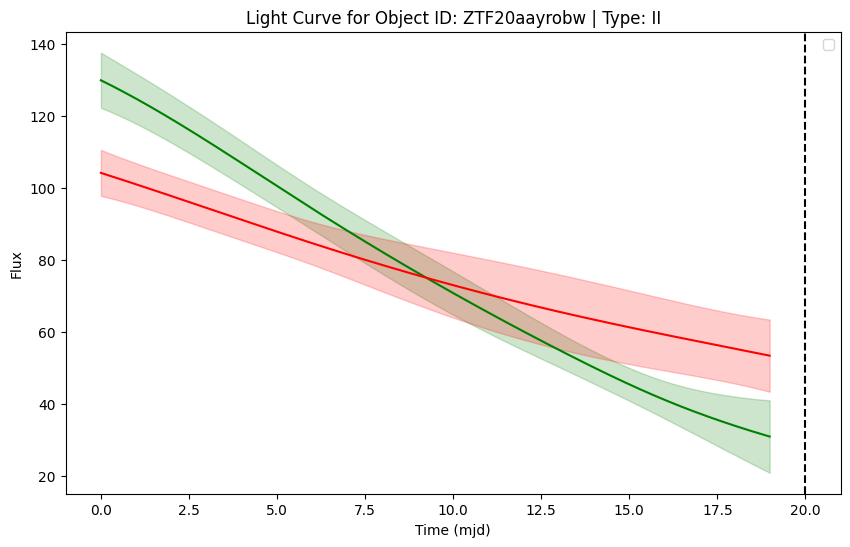

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


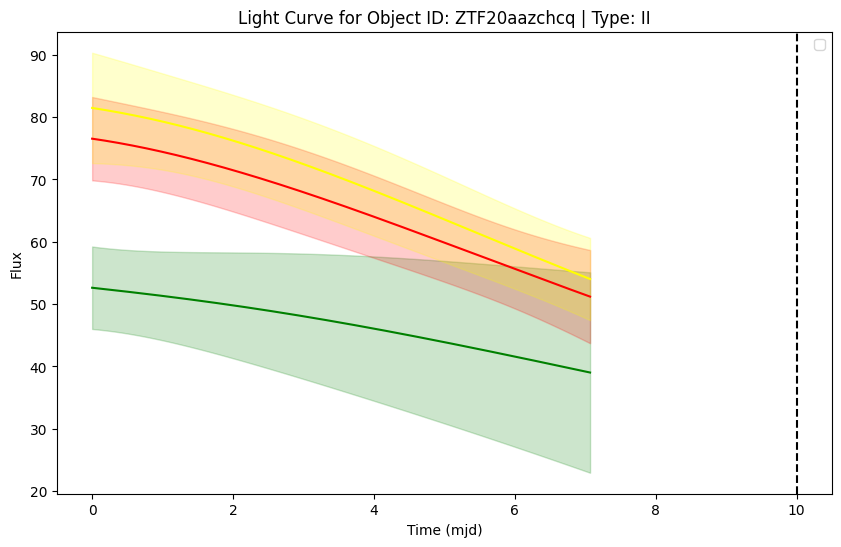

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


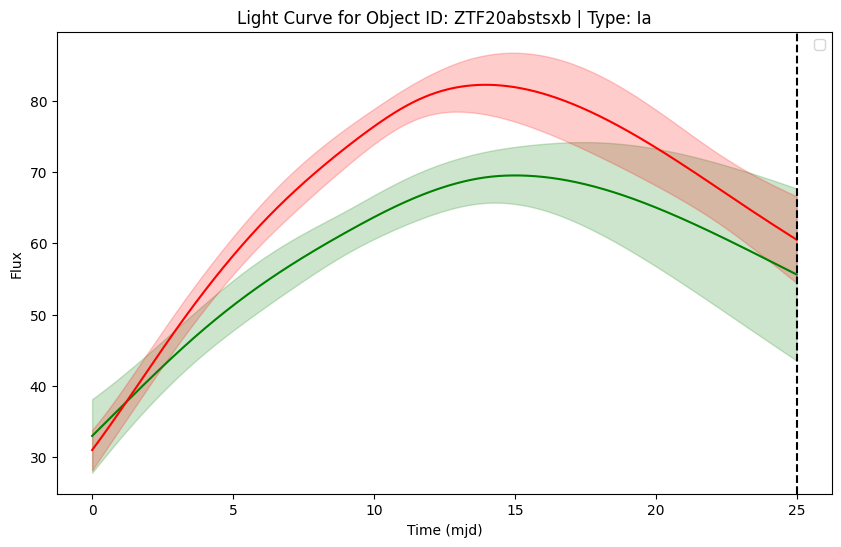

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


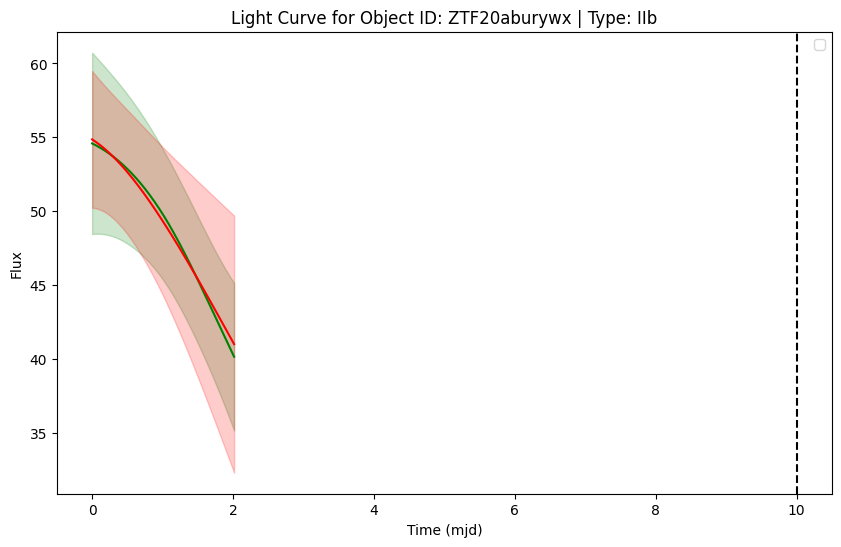

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


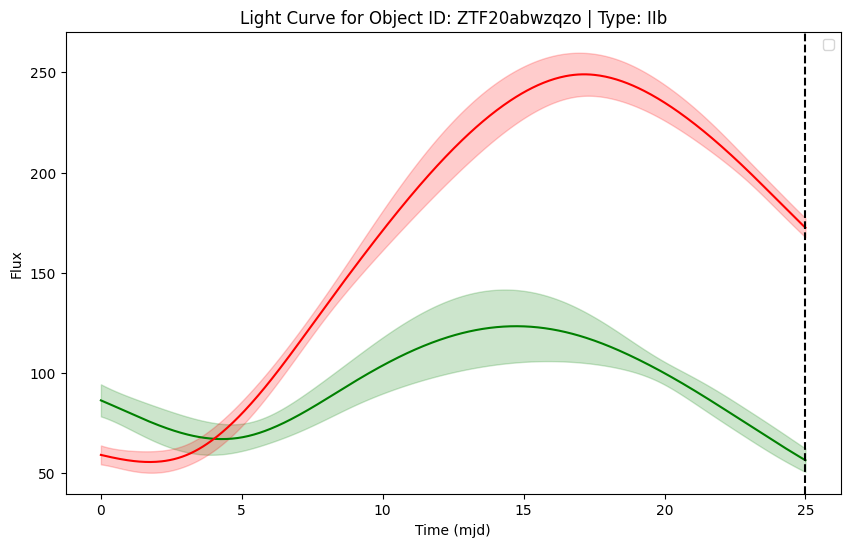

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


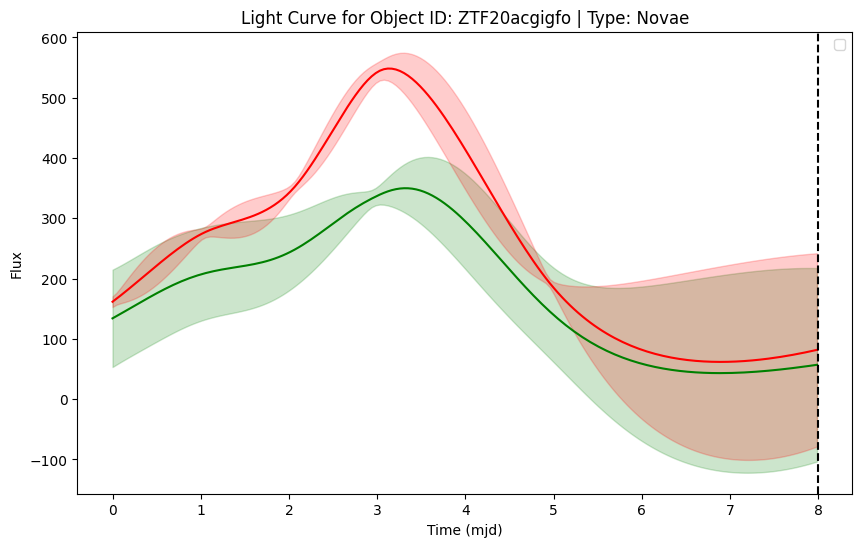

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


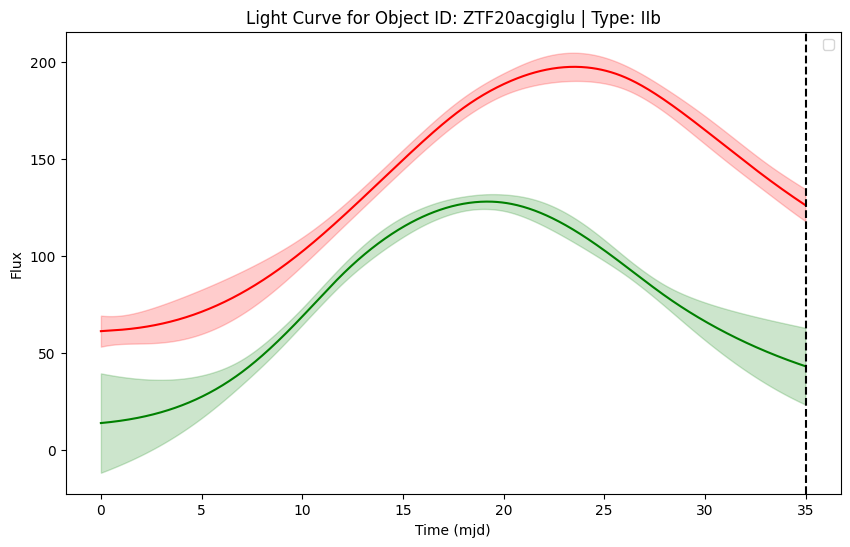

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


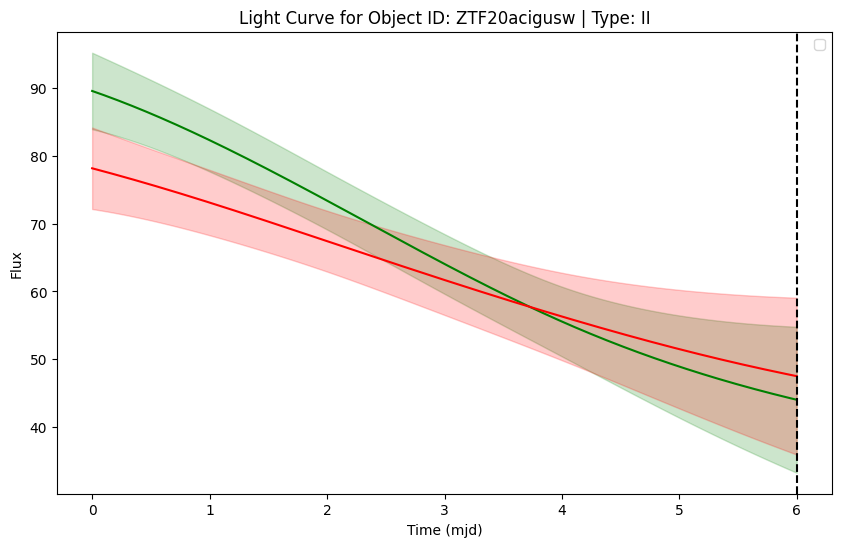

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


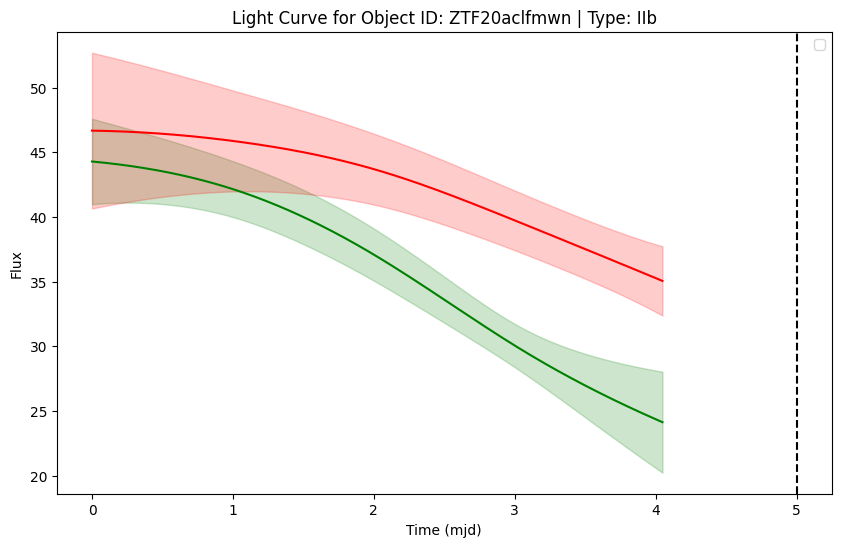

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


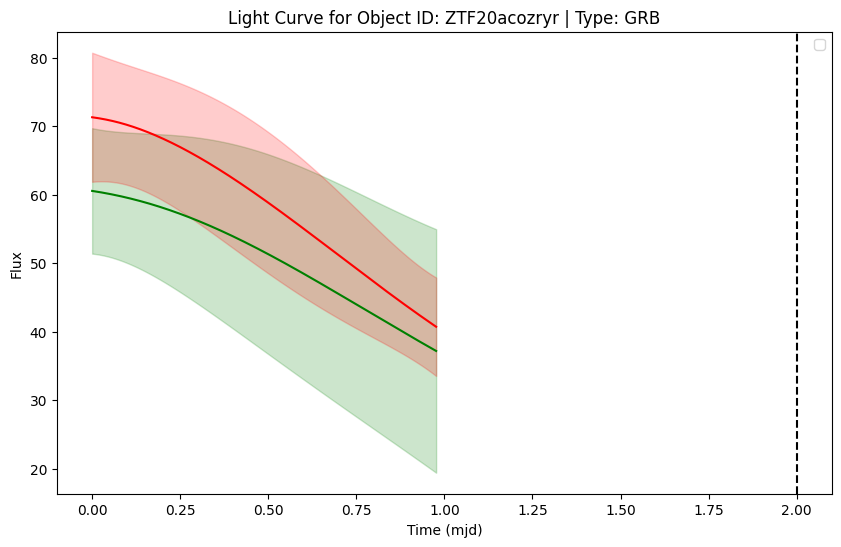

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


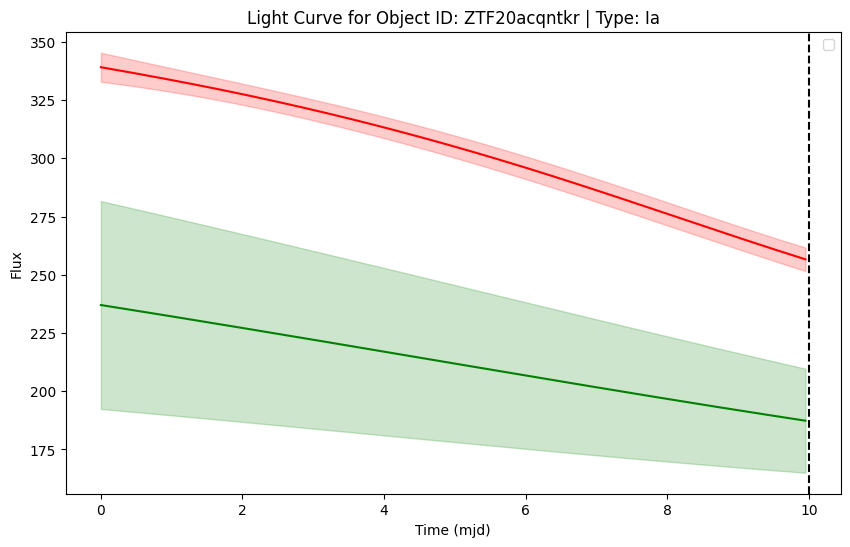

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


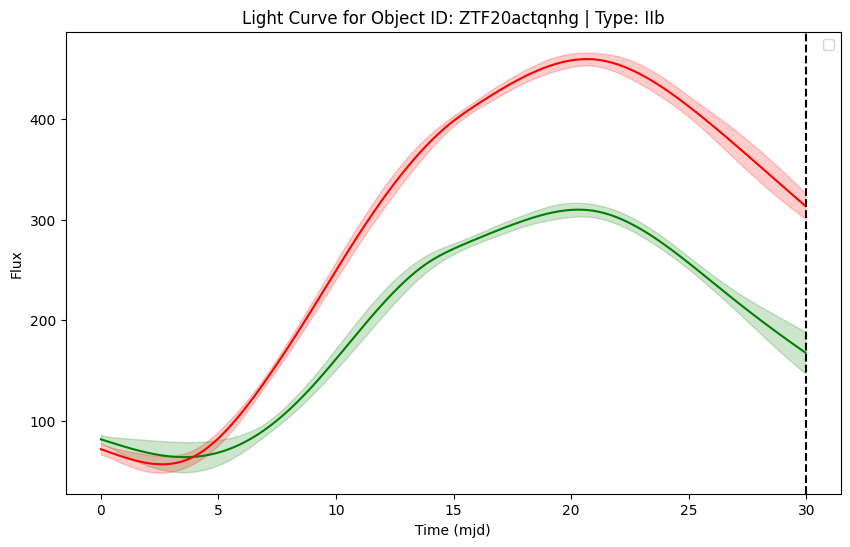

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


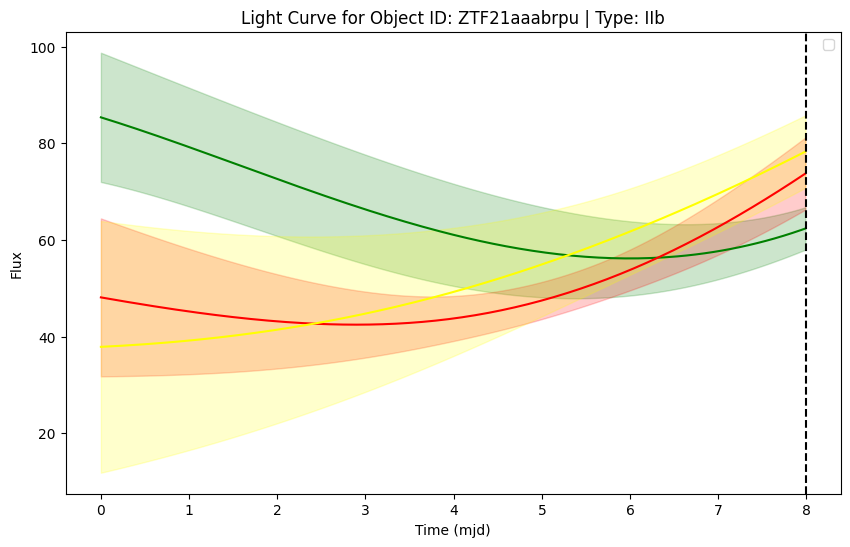

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


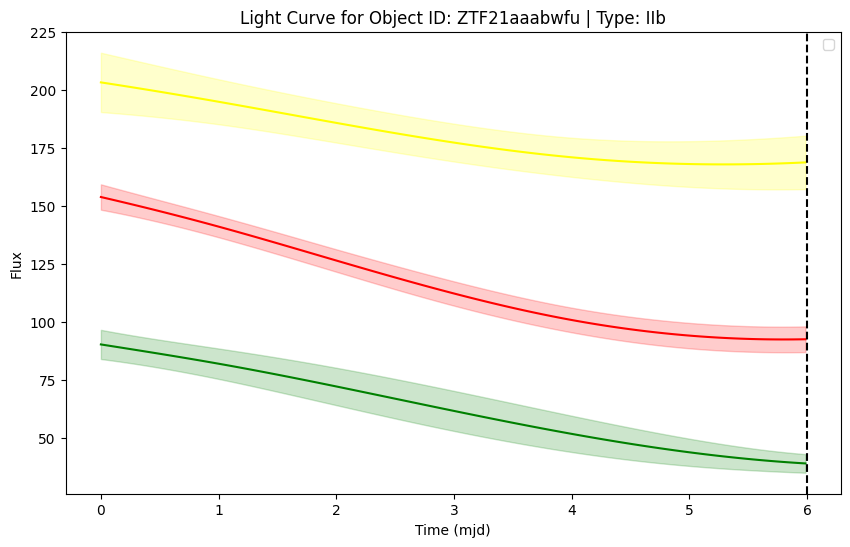

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


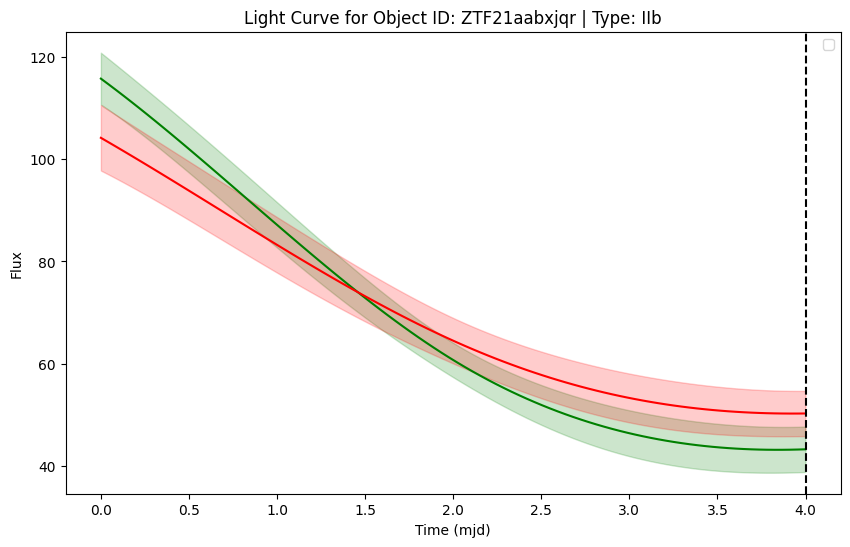

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


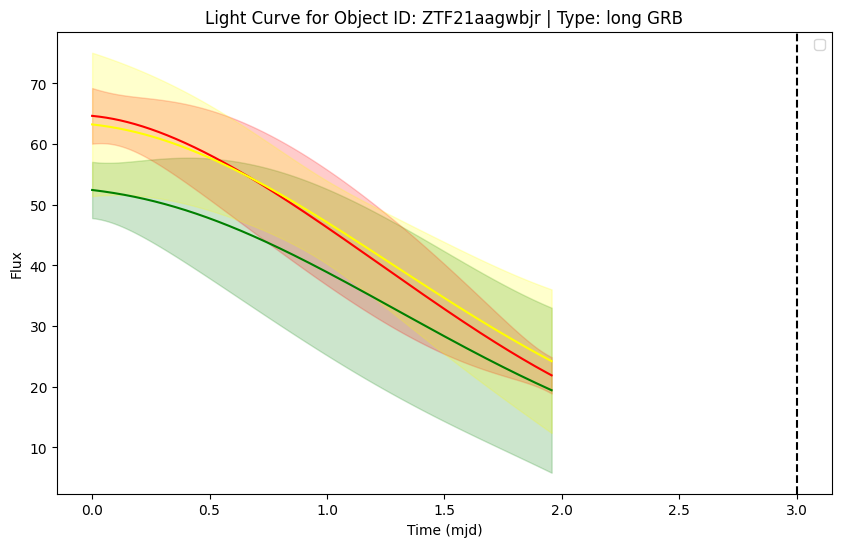

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


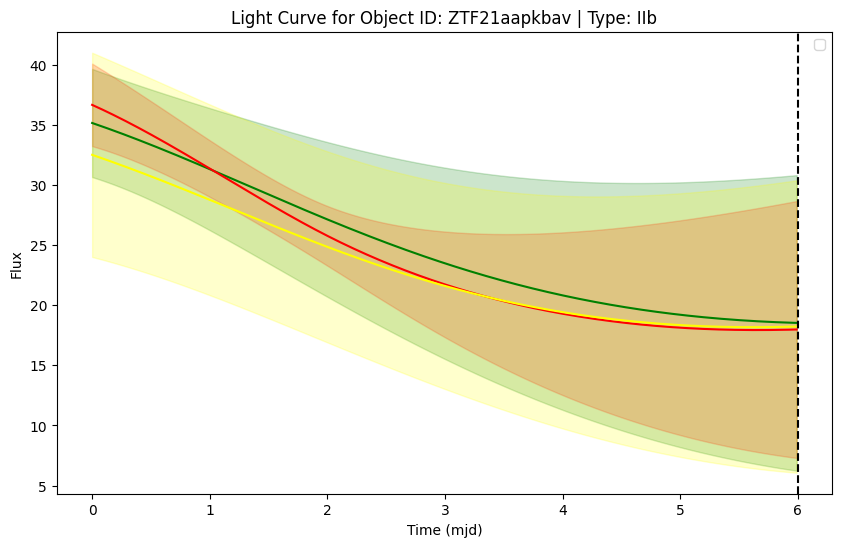

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


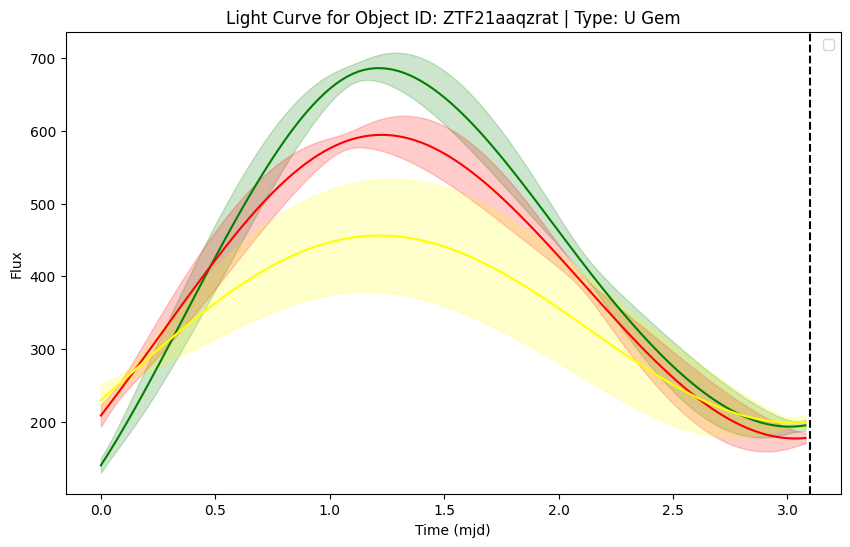

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


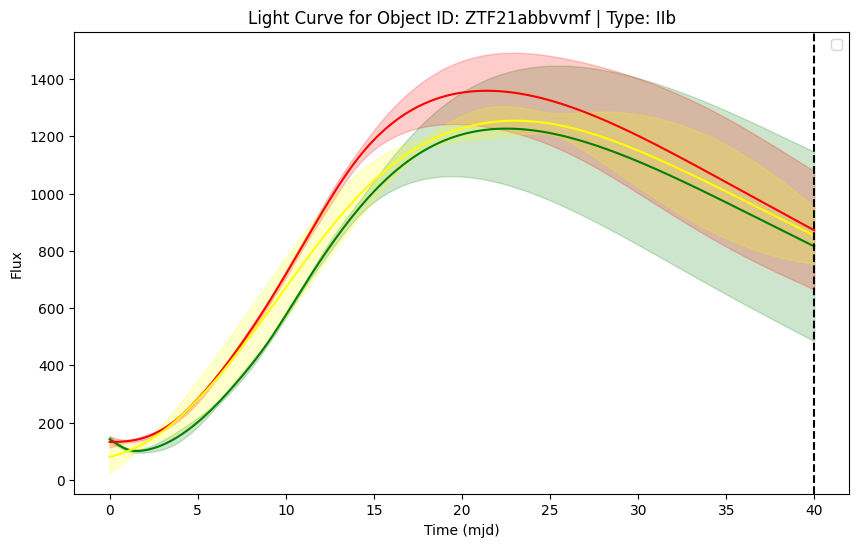

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


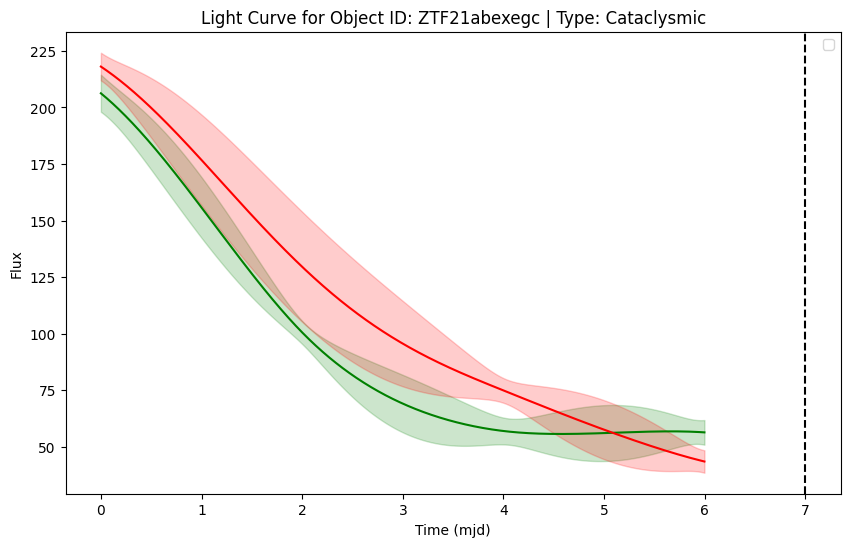

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


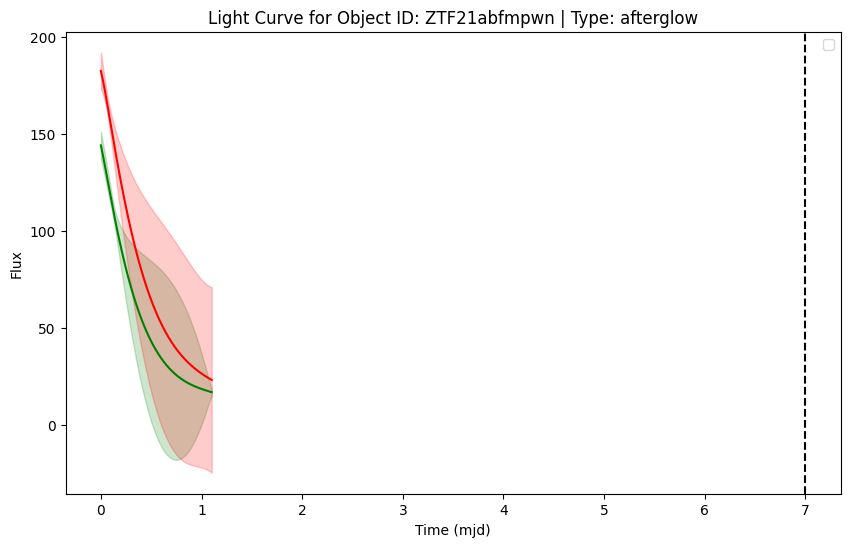

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


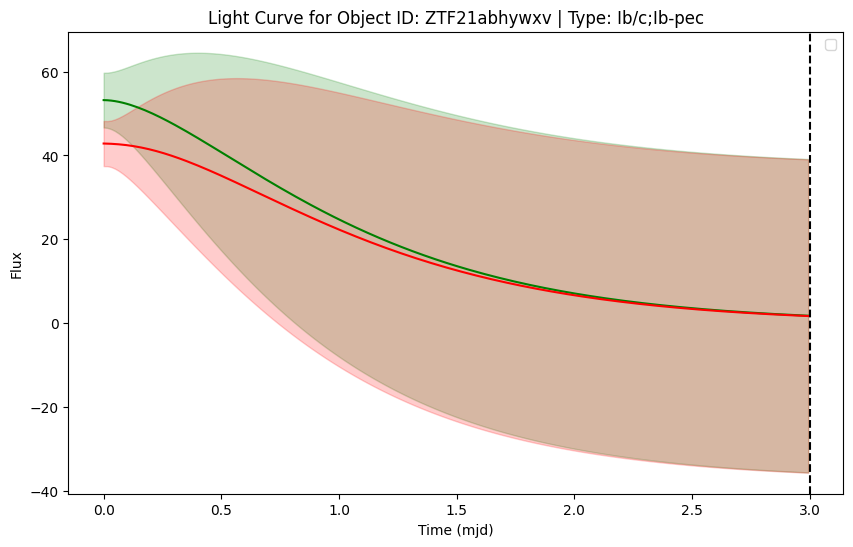

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


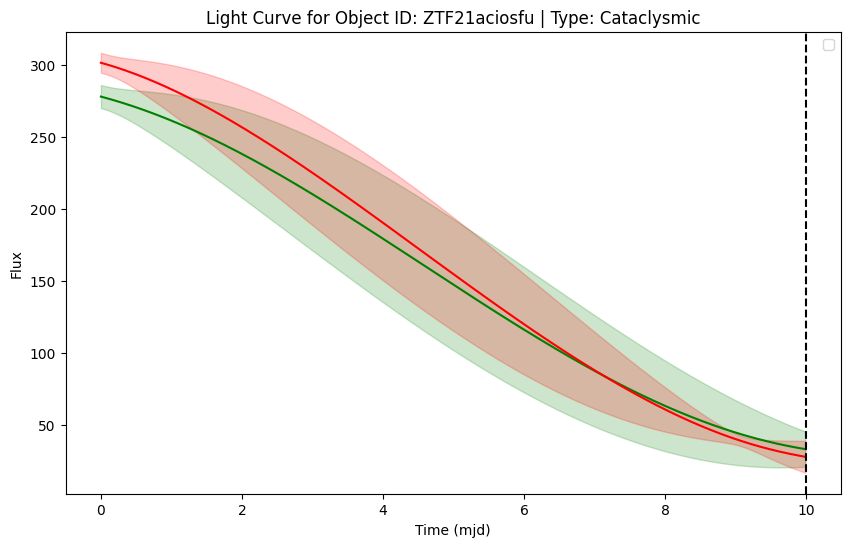

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


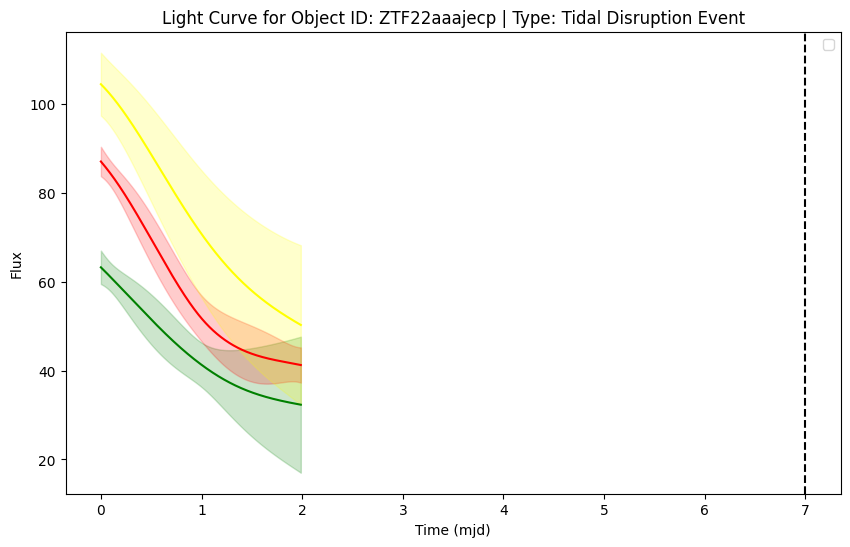

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


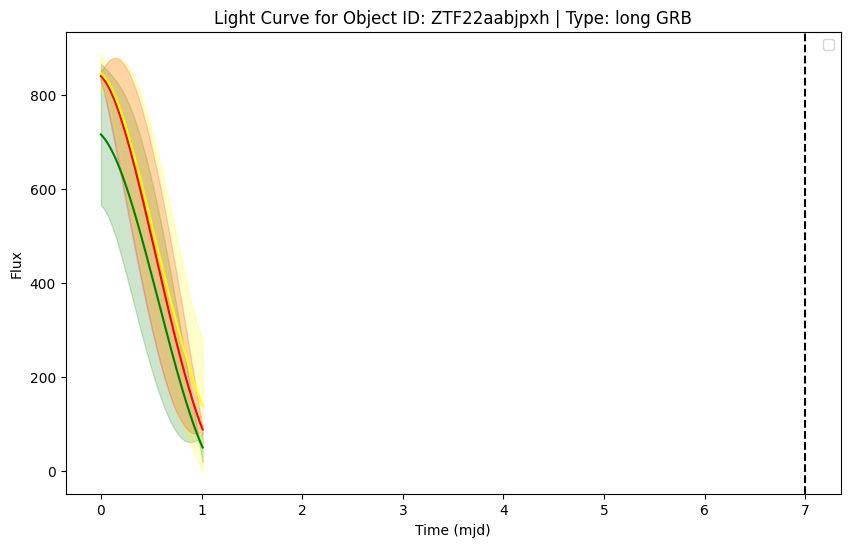

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


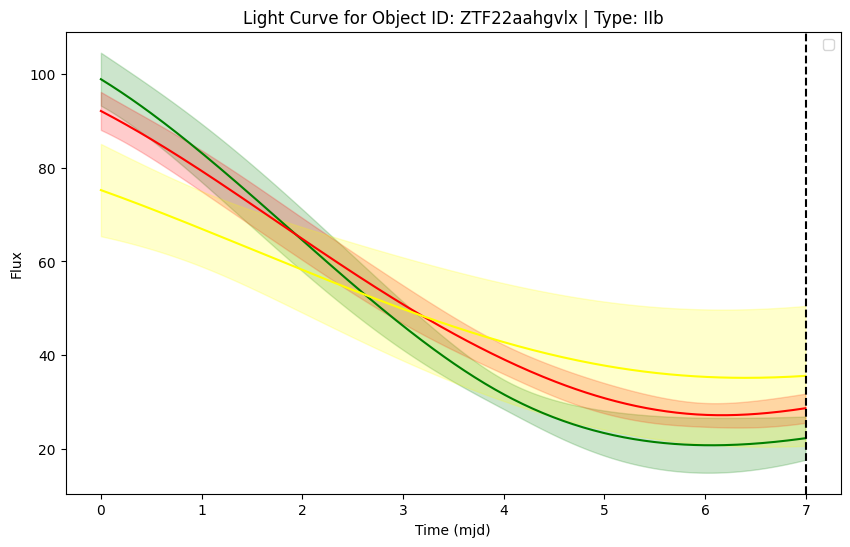

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


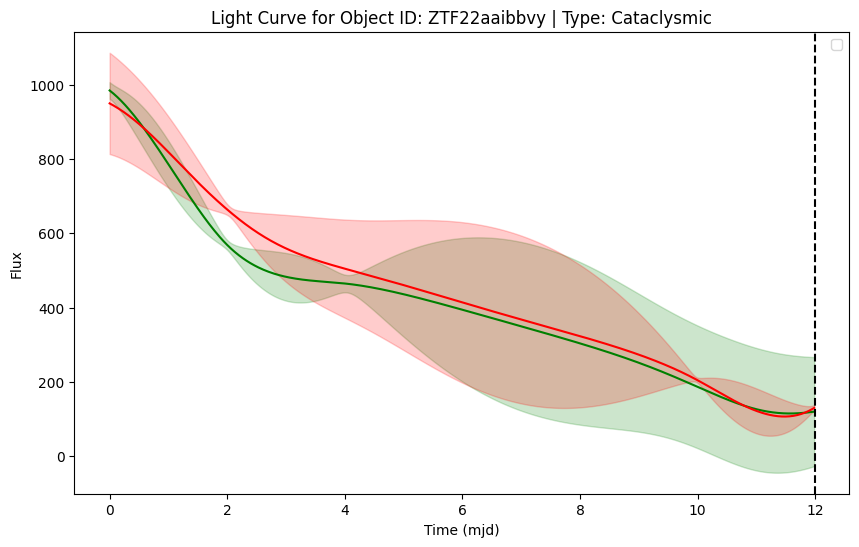

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


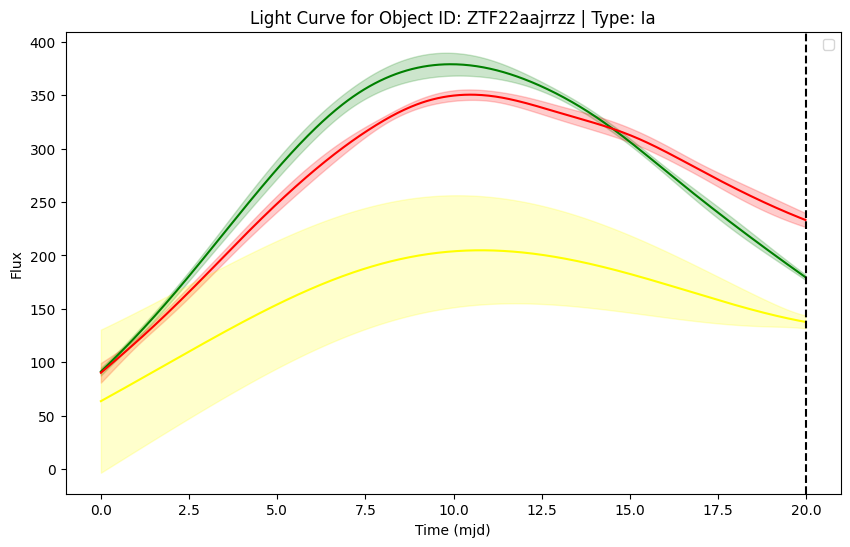

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


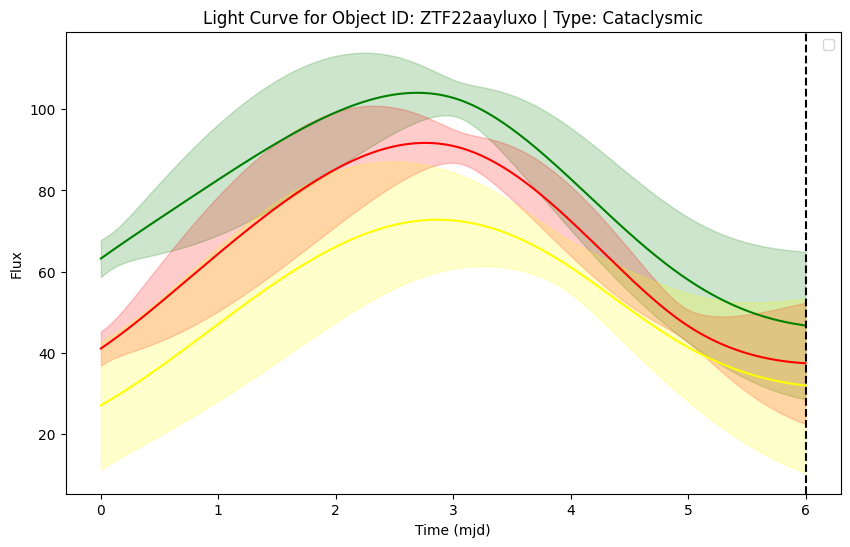

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


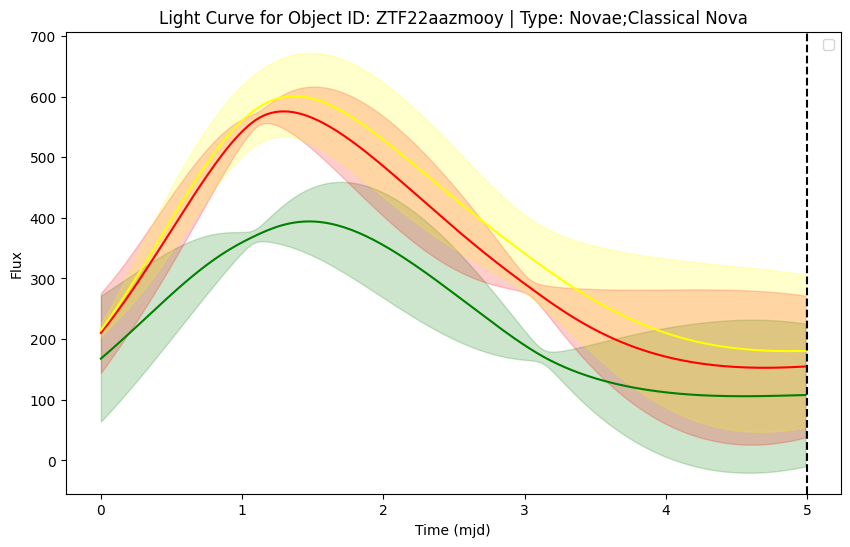

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


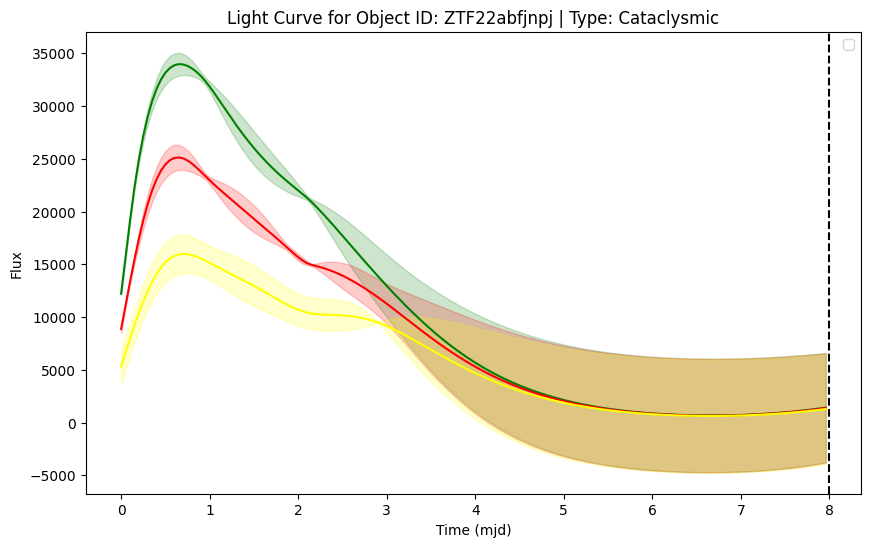

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


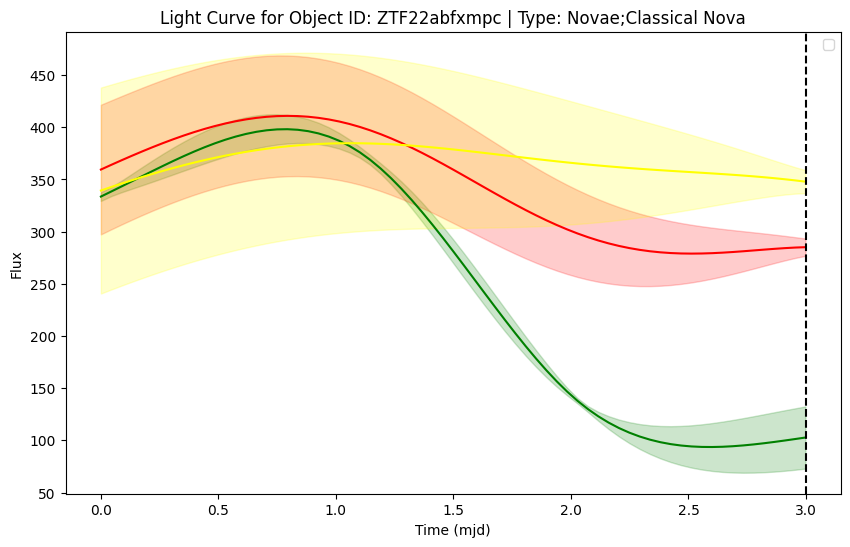

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


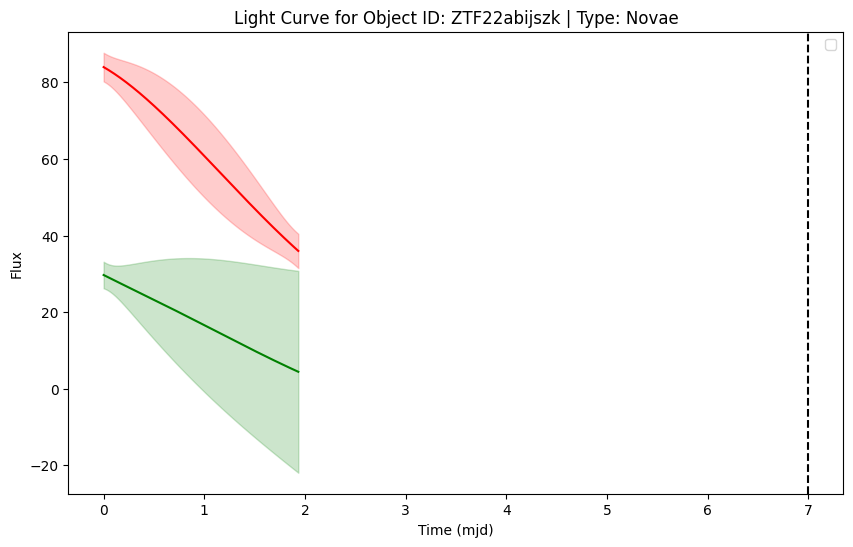

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


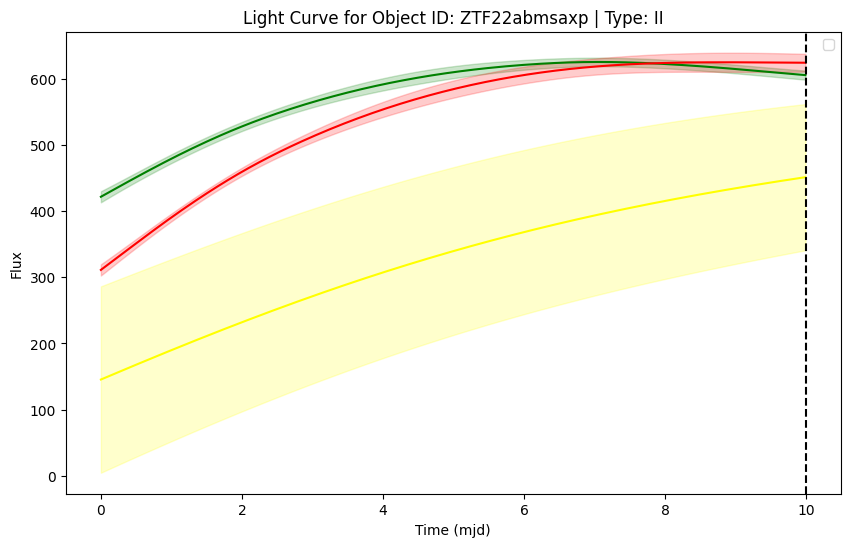

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


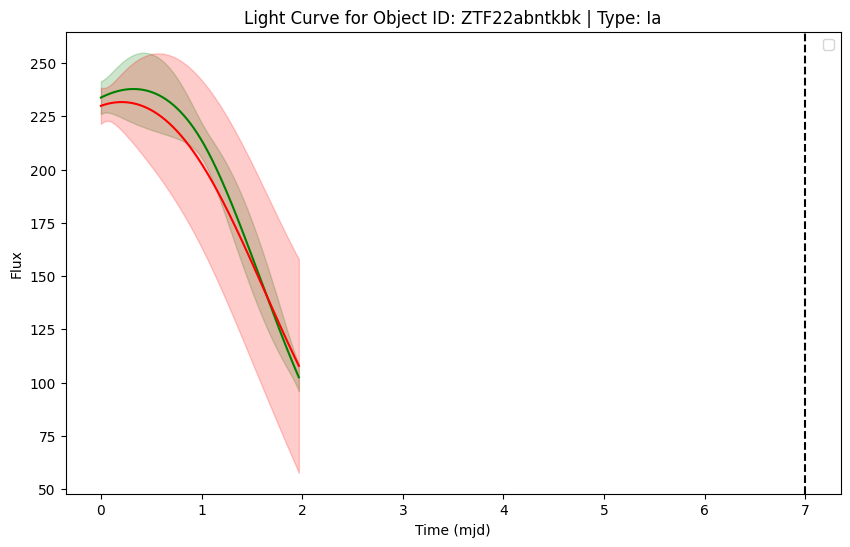

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


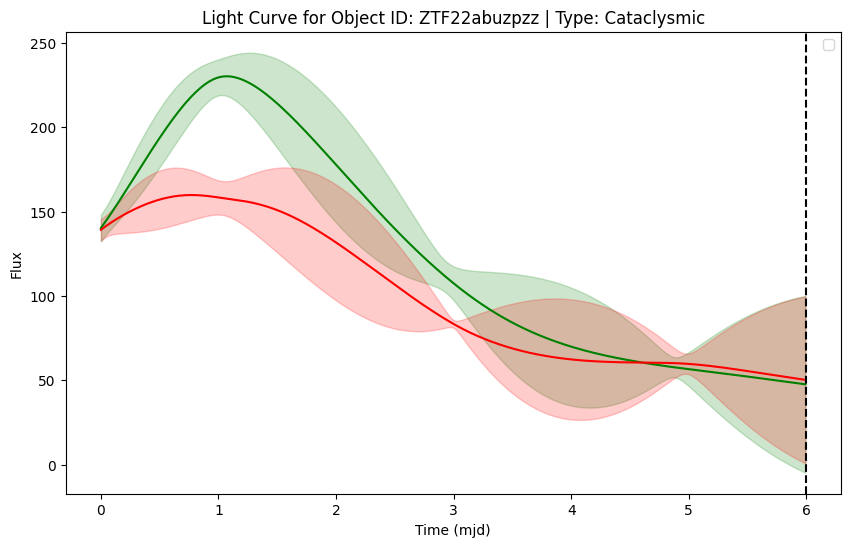

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


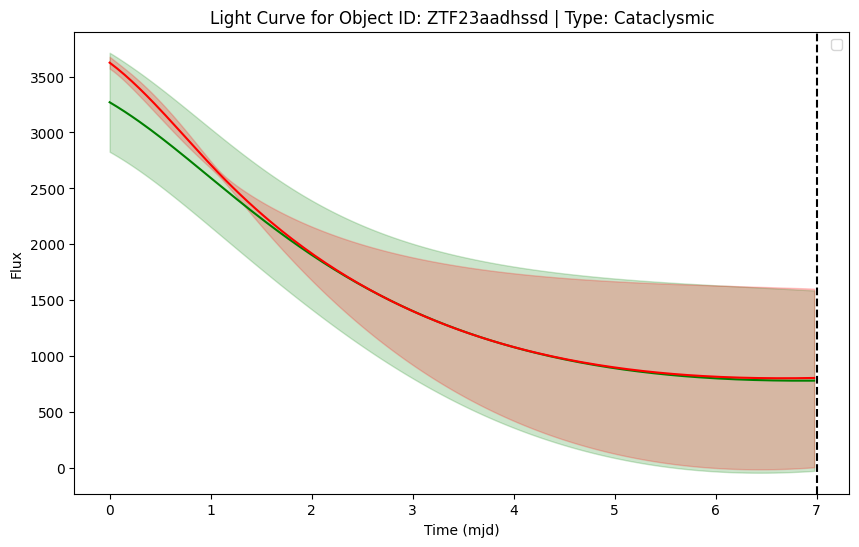

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


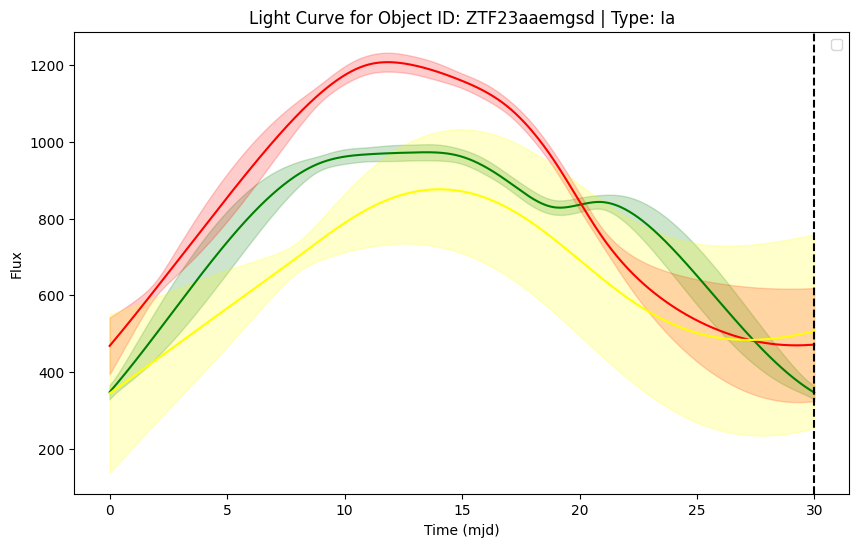

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


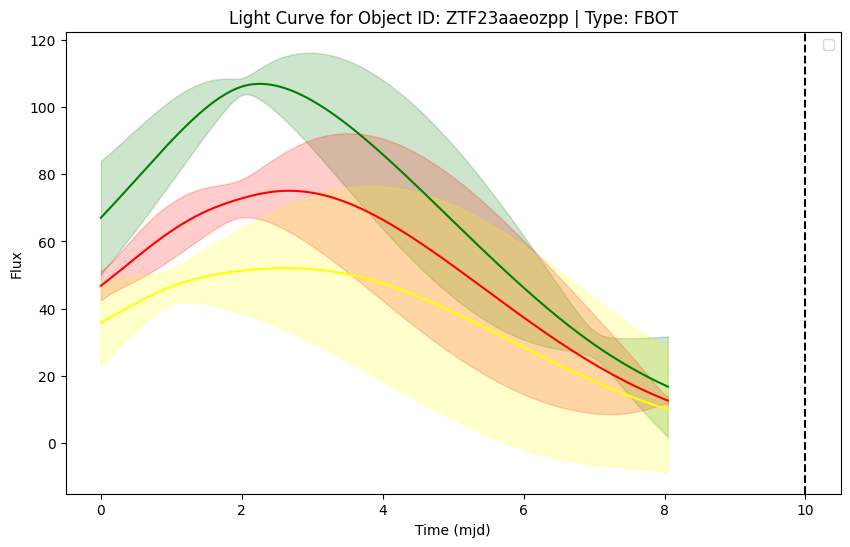

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


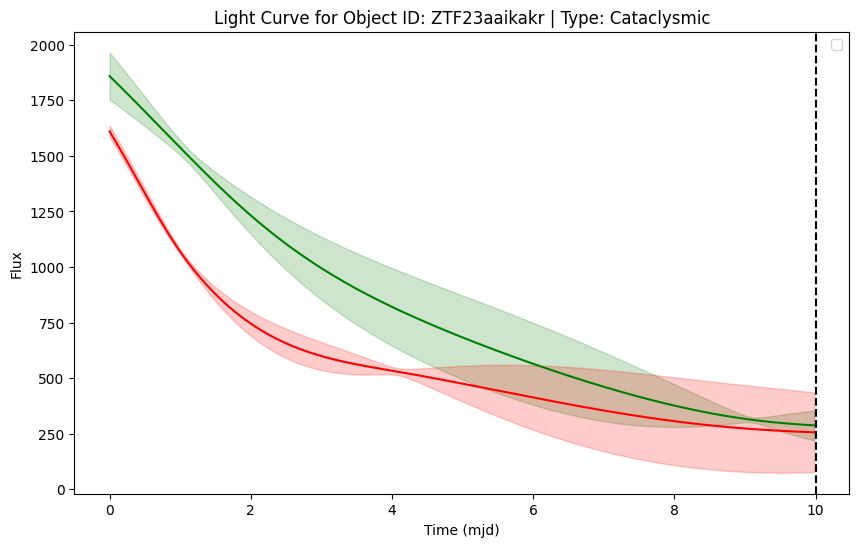

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


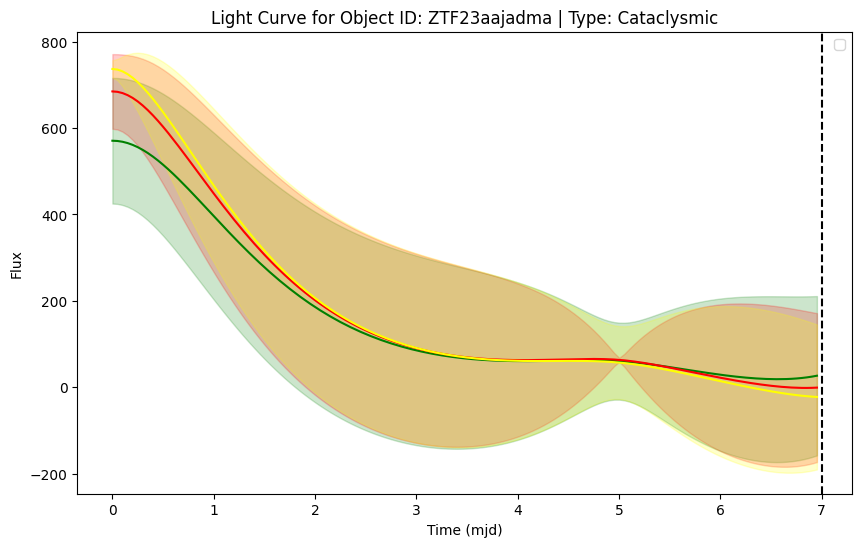

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


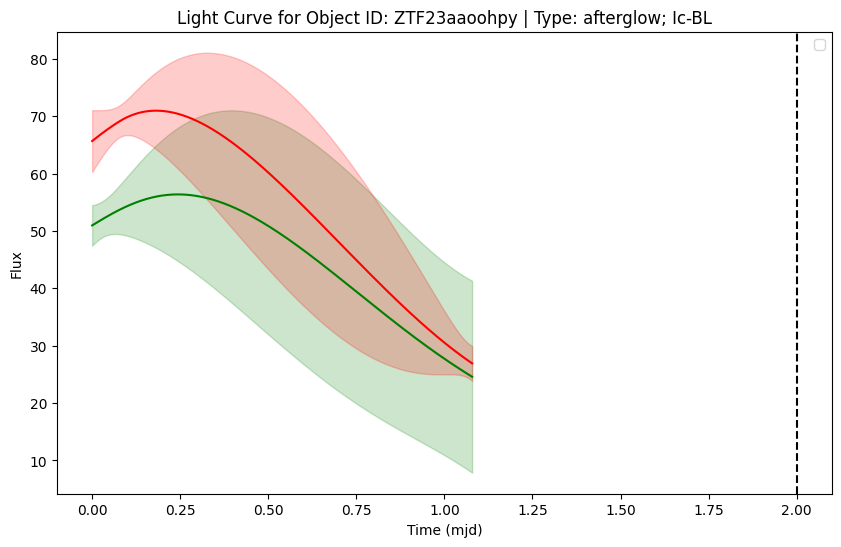

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


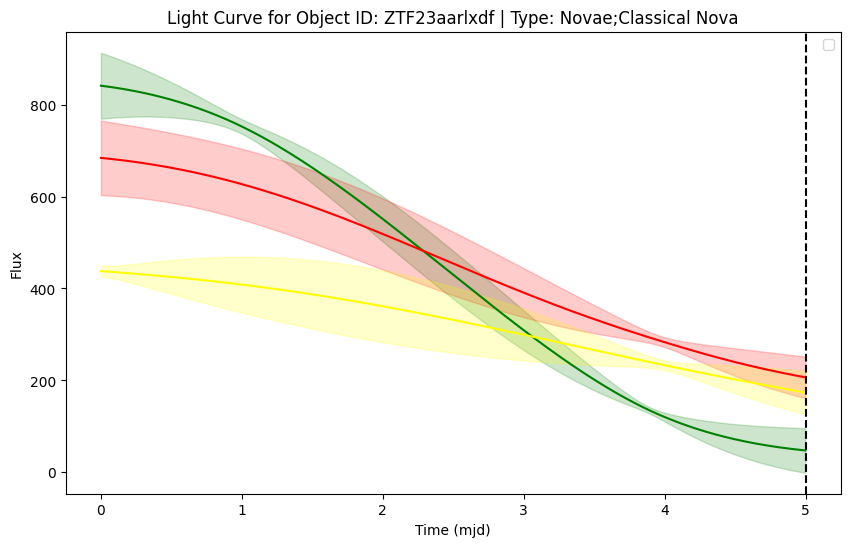

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


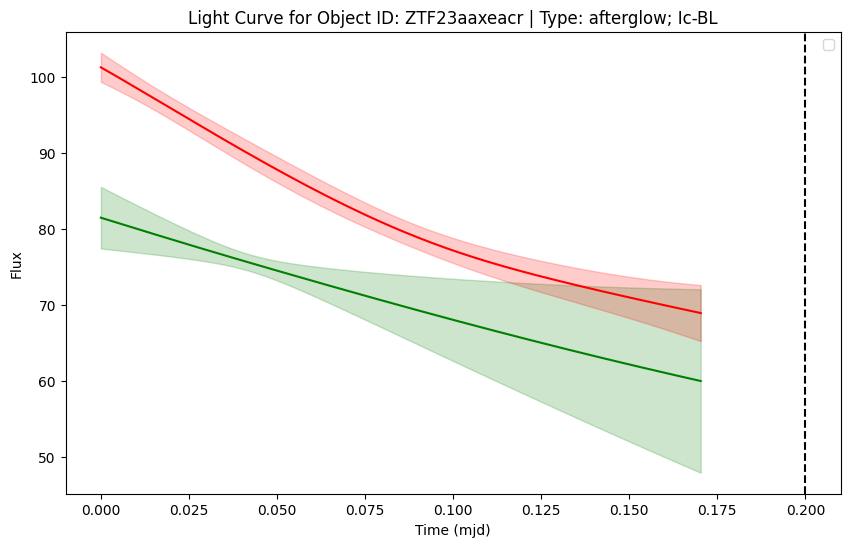

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


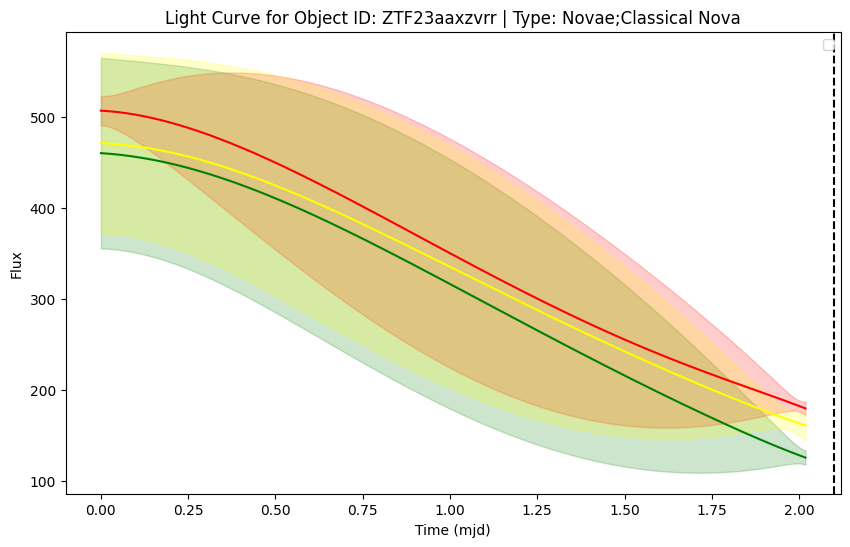

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


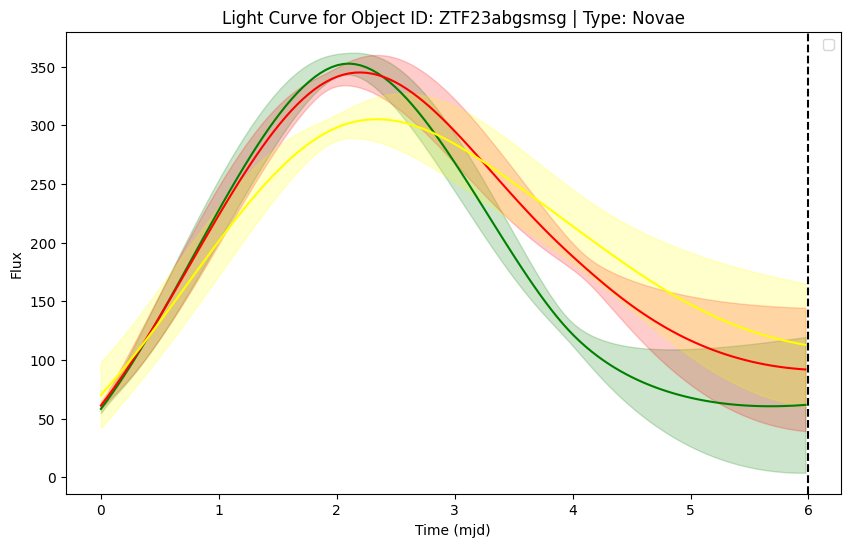

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


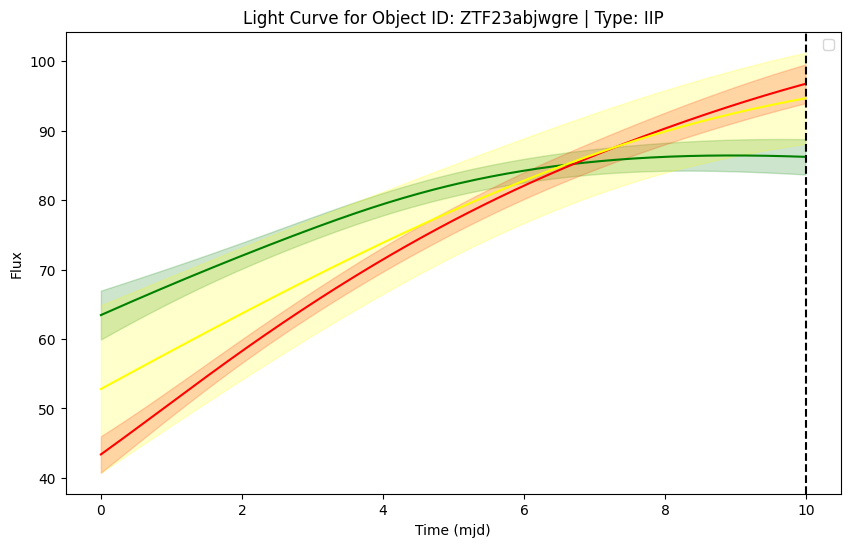

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


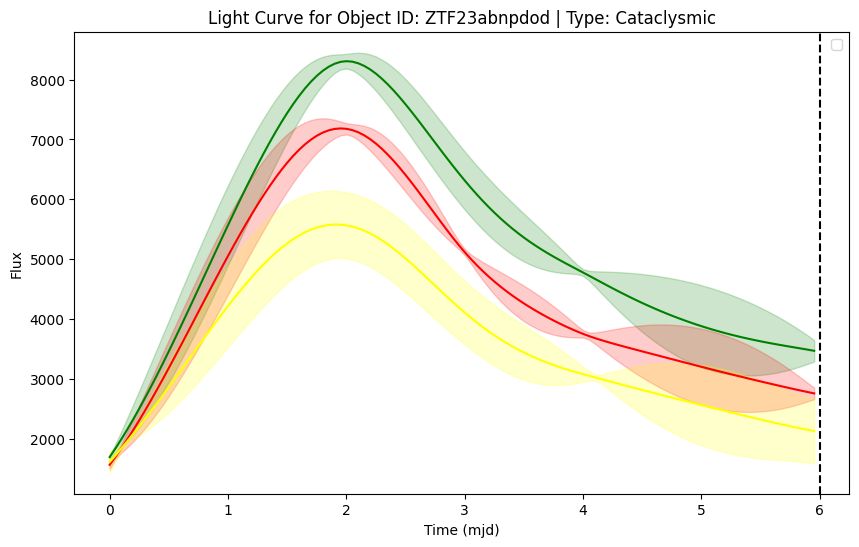

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


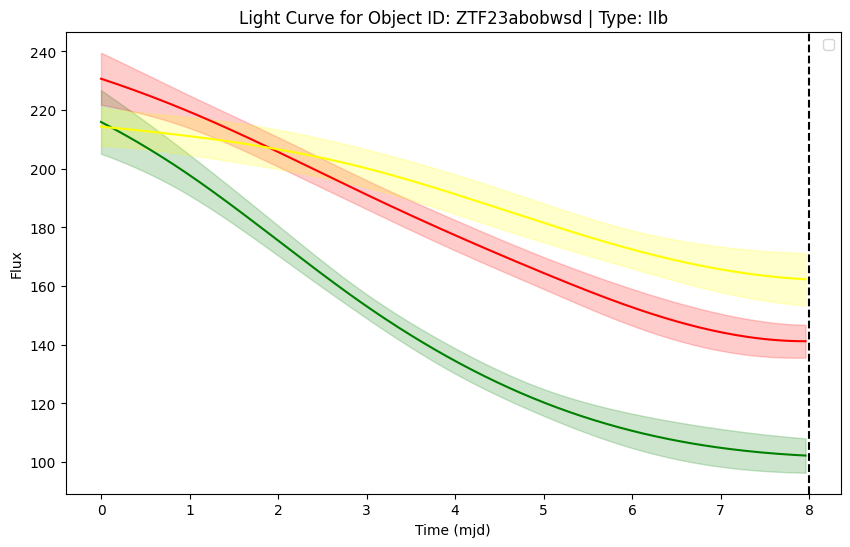

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


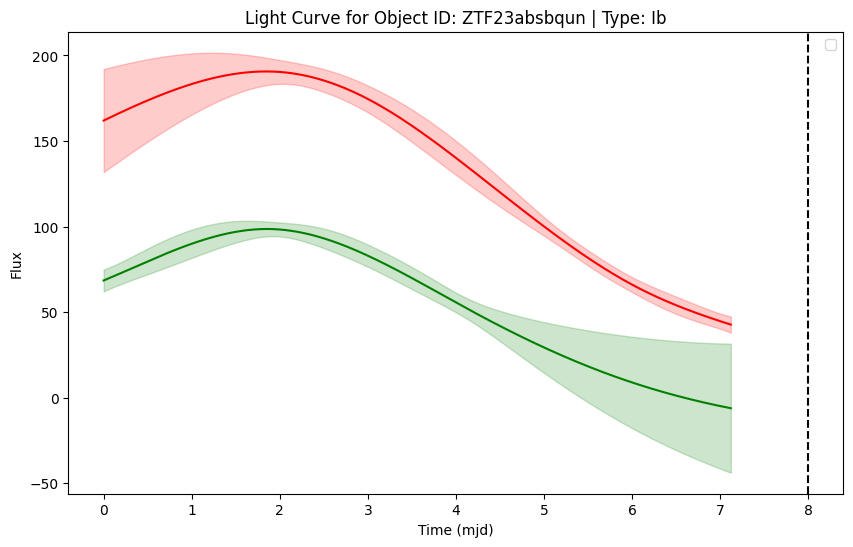

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


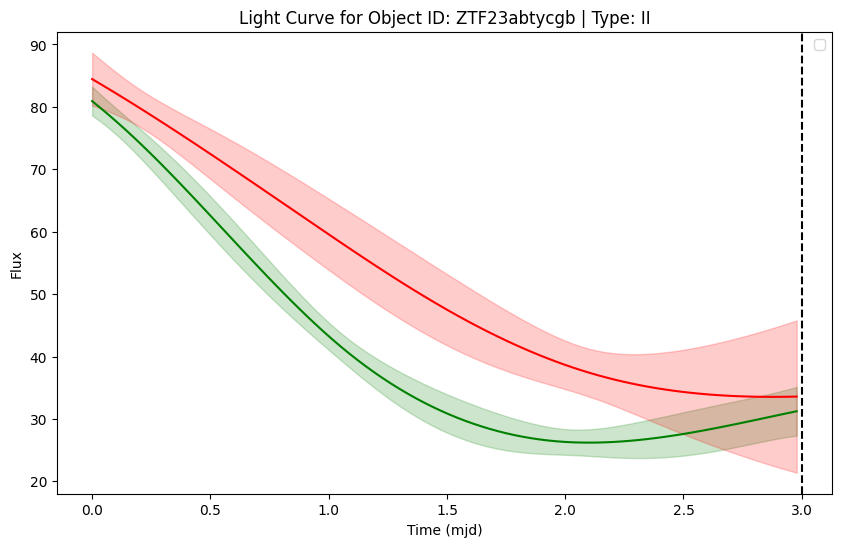

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


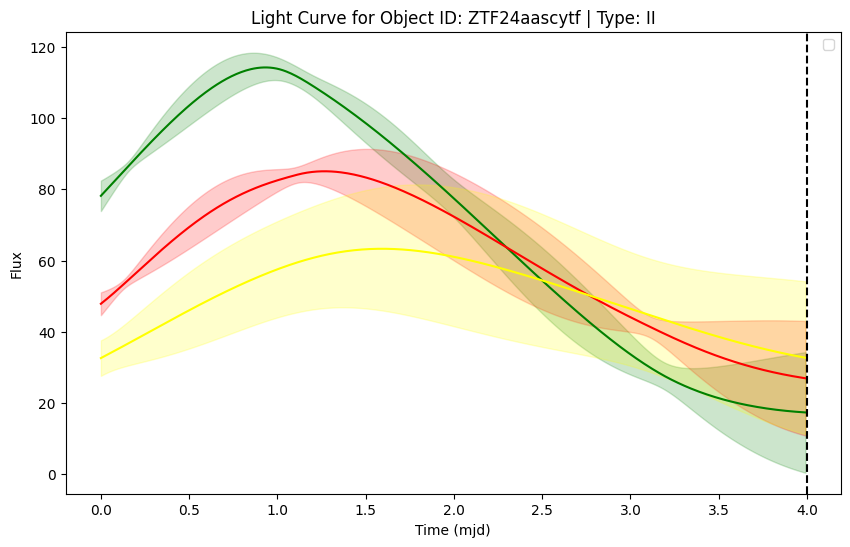

In [23]:
df = cut_data(df,obj[0], 15)
df = cut_data(df,obj[1], 7)
df = cut_data(df,obj[2], 10)
df = cut_data(df,obj[3], 12)
df = cut_data(df,obj[4], 12)
df = cut_data(df,obj[5], 23)
df = cut_data(df,obj[6], 15)
df = cut_data(df,obj[7], 12)
df = cut_data(df,obj[8], 6)
df = cut_data(df,obj[9], 3)
df = cut_data(df,obj[10], 25)
df = cut_data(df,obj[11], 11)
df = cut_data(df,obj[12], 10)
df = cut_data(df,obj[13], 20)
df = cut_data(df,obj[14], 6)
df = cut_data(df,obj[15], 10)
df = cut_data(df,obj[16], 13)
df = cut_data(df,obj[17], 20)
df = cut_data(df,obj[18], 10)
df = cut_data(df,obj[19], 25)
df = cut_data(df,obj[20], 10)
df = df[df['obj_id'] != obj[21]] ## ztfabwysqy not suited to GP
df = cut_data(df,obj[22], 25)
df = cut_data(df,obj[23], 8)
df = cut_data(df,obj[24], 35)
df = cut_data(df,obj[25], 6)
df = cut_data(df,obj[26], 5)
df = cut_data(df,obj[27], 2)
df = cut_data(df,obj[28], 10)
df = cut_data(df,obj[29], 30)
df = cut_data(df,obj[30], 8)
df = cut_data(df,obj[31], 6)
df = cut_data(df,obj[32], 4)
df = cut_data(df,obj[33], 3)
df = cut_data(df,obj[34], 6)
df = cut_data(df,obj[35], 3.1)
df = cut_data(df,obj[36], 40)
df = cut_data(df,obj[37], 7)
df = cut_data(df,obj[38], 7)
df = cut_data(df,obj[39], 3)
df = cut_data(df,obj[40], 10)
df = cut_data(df,obj[41], 7)
df = cut_data(df,obj[42], 7)
df = cut_data(df,obj[43], 7)
df = cut_data(df,obj[44], 12)
df = cut_data(df,obj[45], 20)
df = cut_data(df,obj[46], 6)
df = cut_data(df,obj[47], 5)
df = cut_data(df,obj[48], 8)
df = cut_data(df,obj[49], 3)
df = cut_data(df,obj[50], 7)
df = cut_data(df,obj[51], 10)
df = cut_data(df,obj[52], 7)
df = cut_data(df,obj[53], 6)
df = df[df['obj_id'] != obj[54]]
df = cut_data(df,obj[55], 7)
df = cut_data(df,obj[56], 30)
df = cut_data(df,obj[57], 10)
df = cut_data(df,obj[58], 10)
df = df[df['obj_id'] != obj[59]]
df = cut_data(df,obj[60], 7)
df = cut_data(df,obj[61], 2)
df = cut_data(df,obj[62], 5)
df = cut_data(df,obj[63], 0.2)
df = cut_data(df,obj[64], 2.1)
df = cut_data(df,obj[65], 6)
df = cut_data(df,obj[66], 10)
df = cut_data(df,obj[67], 6)
df = cut_data(df,obj[68], 8)
df = df[df['obj_id'] != obj[69]]
df = cut_data(df,obj[70], 8)
df = cut_data(df,obj[71], 3)
df = cut_data(df,obj[72], 4)

In [24]:
# df.to_csv('gp_objects(downsample).csv', index=False)

In [16]:
[print(x) for x in df.obj_id.unique()];

ZTF18aakuewf
ZTF18aalrxas
ZTF18abffyqp
ZTF18abvkmgw
ZTF18abwkrbl
ZTF19aanbpus
ZTF19aapfmki
ZTF19aatesgp
ZTF19abacxod
ZTF19abxjrge
ZTF19abxtcio
ZTF19abyjzvd
ZTF19acbumks
ZTF19accjfgv
ZTF20aahfqpm
ZTF20aajnksq
ZTF20aaxhzhc
ZTF20aayrobw
ZTF20aazchcq
ZTF20abstsxb
ZTF20aburywx
ZTF20abwzqzo
ZTF20acgigfo
ZTF20acgiglu
ZTF20acigusw
ZTF20aclfmwn
ZTF20acozryr
ZTF20acqntkr
ZTF20actqnhg
ZTF21aaabrpu
ZTF21aaabwfu
ZTF21aabxjqr
ZTF21aagwbjr
ZTF21aapkbav
ZTF21aaqzrat
ZTF21abbvvmf
ZTF21abexegc
ZTF21abfmpwn
ZTF21abhywxv
ZTF21aciosfu
ZTF22aaajecp
ZTF22aabjpxh
ZTF22aahgvlx
ZTF22aaibbvy
ZTF22aajrrzz
ZTF22aayluxo
ZTF22aazmooy
ZTF22abfjnpj
ZTF22abfxmpc
ZTF22abijszk
ZTF22abmsaxp
ZTF22abntkbk
ZTF22abuzpzz
ZTF23aadhssd
ZTF23aaemgsd
ZTF23aaeozpp
ZTF23aaikakr
ZTF23aajadma
ZTF23aaoohpy
ZTF23aarlxdf
ZTF23aaxeacr
ZTF23aaxzvrr
ZTF23abgsmsg
ZTF23abjwgre
ZTF23abnpdod
ZTF23abobwsd
ZTF23absbqun
ZTF23abtycgb
ZTF24aascytf
